# VARify


## Workflow


<img src="wf.png" width="600">

# Functions

In [1]:
# Utility File

# libraries
import warnings
import pandas as pd

asciiDict = {chr(i):(i-33) for i in range(33,74)}
ntRevDict = {"A":"T", 
             "T":"A",
             "G":"C",
             "C":"G"}

def snpCheck(strand, snp): 
    '''
    Checks for pos/neg strand
    returns SNP
    '''
    
    if strand == '-':
        return ntRevDict.get(snp)
    else:
        return snp
    
def varify(x, mp):
    # dictionary of alternate codons from pileup
    # alt_dict = altDict(mp)
    
    # running the script
    snp_df = x.apply(axis=1, func=snpDict)
    snp_df = pd.concat(list(snp_df))
    df = pd.merge(x, snp_df, on='snp_pos')

    # Add the dictionary
    df = df.apply(axis=1, func=translate)
    df = df.apply(axis=1, func=altValidate)
    df = df.apply(axis=1, func=codonVarify)
    df = df.apply(axis=1, func=aaVarify)
    df = df.drop(columns='pileup', axis=1)
    
    reorg = ['chr_id', 'snp_pos', 'ref_allele', 'alt_allele', 'gene_id', 'mrna_id',
             'prot_id', 'strand', 'effect', 'snp_cds_pos', 'codon1_genome_pos',
             'codon2_genome_pos', 'codon3_genome_pos', 'snp_aa_pos', 'ref_codon',
             'alt_codon', 'ref_aa', 'alt_aa', #'ref', 
             'pos1_pileup', 'pos2_pileup', 'pos3_pileup',
             'varify_codon', 'varify_allele',
             'varify_aa', 'nt_VARified', 'codon_VARified', 'aa_VARified','comment']
    return df[reorg]



def snpDict(x):
    # import itertools # for permutations
    #print(x.snp_pos)
    # Takes the current position of SNP
    p3 = int(x.codon3_genome_pos)
    p2 = int(x.codon2_genome_pos)
    p1 = int(x.codon1_genome_pos)
    subDict = {p1 : '.', p2 : '.', p3 : '.'}

    
    # Fills dictionary with SNP of position from mpileup
    res_dict = {key: alt_dict.get(key, subDict[key]) for key in subDict}
    res = ''.join(res_dict.values())
    
    pos_check = False
    pos_list = [p1, p2, p3]
#     print(pos_list)
#     print(subDict)
    
    # If there are any differences between RNA & DNA, return position
    if pos != False: 
        for p in pos_list:
            if p in pos:
                # only add p into pos_dict
                pos_check = True
                #snp = snpCheck(x.strand, alt_dict.get(p))
                pos_dict = {p: alt_dict.get(p)}
                #print(pos_dict)
                #pos_dict = {key:val for key, val in pos_dict.items() if val != '.'}
    
    # starts from reference 
    ref = list(x['ref_codon']) 
    
    # create a new dictionary
    snp_dict = {}
    multi_check = False
    comment=''
    flag = ''
    
    # create pileup in df
    for i in range(len(pos_list)):
        cname = ['pos1_pileup', 'pos2_pileup', 'pos3_pileup']
        
        try:
            snp_dict[cname[i]] = mp[mp.snp_pos == pos_list[i]].pileup.tolist()[0]
        except:
            # if the pileup does not have info, replace with *
            snp_dict[cname[i]] = "*"
        
    
    # MultiFlag for complex codons
    if (list(res)).count(".") < 2:
        multi_check = True
        if pos_check == False:
            # if < 2, then there are multi snps 
            flag = 'complex_codon'
        elif pos_check == True: 
            flag = f'NA'
            comment=f'SNP(s) {pos_dict} only in RNA'
        
    if multi_check == True: 
        # if multi_check true, then complex_codon
        snp_dict['varify_codon'] = flag
        snp_dict['snp_pos'] = x['snp_pos']
        current_pos = int(x['snp_pos'])
        snp_dict['varify_allele'] = alt_dict[int(current_pos)] # fill with current pos snp
        snp_dict['comment'] = comment
                                      
    else:
        current_pos = int(x['snp_pos'])
        idx = list(subDict.keys()).index(current_pos)
        # get ref
        try:
            ref[idx] = snpCheck(x.strand, alt_dict[current_pos])
            snp_dict['varify_allele'] = alt_dict[current_pos] # fill with current pos snp
        except: 
            ref[idx] = snpCheck(x.strand, x.ref_allele)
            snp_dict['varify_allele'] = x.ref_allele
        
        snp_dict['varify_codon'] = ''.join(ref)
        snp_dict['snp_pos'] = x['snp_pos']
        snp_dict['comment'] = comment

        
    snp_df = pd.DataFrame([snp_dict])


    return snp_df

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def getAlt(x):
    indel = has_numbers(x.pileup)
    l = list(x['pileup'])
    nts = ['A','C','T','G']
    
    # check if indel, then skip
    while indel == True:
        for i in l: 
            if i.isnumeric():
                string = ''.join(l)
                n = int(i)
                idx = l.index(i)
                r = range(idx-1,idx+n+1)
                pat = ''.join(l[r[0]:r[-1]+1])
                string = string.replace(pat, '')
        l = [i for i in string]
        indel = has_numbers(string)

    l = [i for i in l if i.isalpha()]
    l = [i for i in l if i.upper() in nts] 
    
    if len(l) == 0:
        x['varify_allele'] = None
    else:   
        # Get list of unique
        a = [i for i in l]
        a = pd.DataFrame(a)
        #a_unique = list(set(a)) 

        # getting max alt
        #a_unique = pd.DataFrame(a_unique)

        # Get the max snp
        #nt = a_unique.groupby([0]).apply(lambda x: x.value_counts().index[0])[0]
        #nt = nt[0]
        #nt = pd.value_counts(a_unique[0].values.flatten()).index[0]
        nt = pd.value_counts(a.values.flatten()).index[0]
        x['varify_allele'] = nt.upper()
    
    return x

def altDict(x):
    
    '''
    Takes mPileup
    Out: mpileup dictionary with snp_pos and varify_allele
    '''
    
    # dataframe of mpileup goes through each pileup with apply
    x = x.apply(axis=1, func=getAlt)
    alt_dict = dict(zip((x['snp_pos']), x['varify_allele']))
    clean_dict = {k: alt_dict[k] for k in alt_dict if pd.isna(alt_dict[k]) == False}
    
    
    return clean_dict

def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

def checkRNADict(x, mp):
    x_dict = altDict(x) # for DNA
    mp_dict = altDict(mp) # for RNA
    
    if str(set(mp_dict)-set(x_dict)) == 'set()':
        return False, mp_dict
    else:
        # returns position difference from RNA 
        return list(set(mp_dict)-set(x_dict)), mp_dict

def readMP(x):
    import pandas as pd
    mp = pd.read_table(x, header=None)
    mp = mp.rename(columns={0:"chr", 1:"snp_pos", 2:"ref", 3:"reads", 4:"pileup"})
    mp = mp[mp.reads >= 1]
    mp = mp.dropna(axis=0)
    return(mp)
    

def aaVarify(x):
    x['aa_VARified'] = 'Yes' if x['varify_aa'] == x['alt_aa'] else "No"
    return x

def codonVarify(x):
    x['codon_VARified'] = 'Yes' if x['varify_codon'] == x['alt_codon'] else 'No'
    return x

def translate(x):
    table = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',}
    
    codon = x['varify_codon']

    if codon not in table.keys():
        x['varify_aa'] = ""
    else:
        x['varify_aa'] =table[codon]
        
    return(x)


# For every row in here, we're going to apply this uniqueSNP function

def mergeTab(mp, so):
    sub_mp = mp[['snp_pos', 'pileup']]
    # sub_mp['snp_pos'] = str(sub_mp['snp_pos'])
    mdf = pd.merge(so, sub_mp, on='snp_pos')
    return mdf


def varOnly(a):
    '''
    purpose: remove non-nt values in pileup
    input: string of mpileup 
    output: nt string
    '''
    x = [i for i in a if i.upper() in ['A','C','T','G']]
    
    return x

def isMono(ref, temp):
    # Check if two snps are monomorphic
    c=0
    count = [c+1 for snp in temp if snp == ref]
    if sum(count) >= 2: 
        warnings.warn("More than 2 monomorphic alleles at position.")
        return True
    else:
        return False

    

def altValidate(x):
    # Varify alt == Alt? T or F
    # Add flag to capture
    
    x['nt_VARified'] = 'Yes' if x['alt_allele'] == x['varify_allele'] else 'No'
    
    return x



def effect(x):
    # missense
    # nonsense
    x['effect'] = '_'
    

###################Older, probably outdated############################

# Codon Combos
import numpy as np
import math 




    

def flatten(d, parent_key='', sep='_'):
    import collections
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# import itertools

# permutations = list(itertools.product(["A","G"], ["T","C"], ["A"]))

# print(permutations)

# ["".join(x) for x in permutations]

---

# Case 1

Consider the following mutation that introduces a G->A mutation.
 
VCF:
Chr1	1100023      	.       	G     	A      	60    	PASS	.       	GT    	0/1
 
* Genotype: G/A
* Reference base: G
* Alternate base: A
* Predicted reference codon: TGG (tryptophan)
* Predicted alternate codon: TGA (premature termination codon)
 
A tool like snpEff can be used to predict the effect of the mutation using a reference genome annotation (e.g., GFF). In this case the mutation occurs in a coding exon at third position of a codon that codes for tryptophan in the reference proteome and a premature termination codon in the case of the alternate allele. snpEff will determine the reference and alternate codon and return the two codons and their translation.
 
The predicted effect is therefore a nonsense mutation.

## Goal Example
| chr_id|snp_pos     | Ref     | Pred_Alt |Varify_Alt|VARified|ref_codon|varify_codon|aa|effect|
| -----------| ----------- | ----------- | ----------- | ----------- | ----------- |----------- |----------- |----------- |----------- |
|Chr1|1100023| G      | A       |A|Yes| TGG | TGA |*|stop_gain|

## Read in the Toy Mpileup File

In [462]:
# mpileup 
mp1 = readMP('../data/test/case1_pileup.txt')

mp1

,chr,snp_pos,ref,reads,pileup
0,Chr1,1100021,T,12,.............
1,Chr1,1100022,G,13,.............
2,Chr1,1100023,G,13,...A...A..A..


## Read in VCF File

In [464]:
# The toy VCF
toy_vcf = pd.read_table('../data/toy/toy.vcf')

toy_vcf

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NA00001
0,Chr1,1100023,.,G,A,60,PASS,.,GT,0/1
1,Chr2,312000,.,G,A,60,PASS,.,GT,0/1
2,Chr2,312001,.,T,C,55,PASS,.,GT,0/1


## Toy SNPeff Table

In [465]:
# Toy Table
toy_snpeff = pd.read_table('../data/toy/toy.snp_effects.tsv')

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,1100021,1100022,1100023,7,TGG,TGA,W,*
1,Chr2,312000,G,A,gene2,mrna2,prot2,+,nonsynonymous,4,312000,312001,312002,2,GTA,ATA,V,I
2,Chr2,312001,T,C,gene2,mrna2,prot2,+,nonsynonymous,5,312000,312001,312002,2,GTA,GCA,V,A


## Merge the mpileup & snpeff table

In [466]:
# Merging the two tables
mp = mp1
x = mergeTab(mp1, toy_snpeff)

# dictionary of alternate codons from pileup
pos, alt_dict = checkRNADict(x, mp)
varify(x, mp)

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,...,.............,.............,...A...A..A..,TGA,A,*,Yes,Yes,Yes,


# Case 1.b and Case 1.c 

To determine if the codon is VARified, VARify will look at the two other positions in the same codon (the ‘non-focal positions’) and determine if ONLY the reference nucleotide is observed in RNA. 

For example, if both non-focal positions are monomorphic for the reference nucleotide in the RNA mpileup (i.e., the reference nucleotide from VCF in snpeff table), then the codon is verified and the “codon_VARified” column will be set to ‘yes’. The Case 1 example above would have the codon_VARified column set to ‘yes’.

All other situations will have the “codon_VARified” column set to “no”. These cases could include cases in which one (or both) non-focal positions have two or more nucleotides in the RNA mpileup (note: this is NOT shown in Case 1 example above). As we discussed, this could occur frequently because of sequencing errors. We will case this “Case 1b”. 

Another situation might be if one (or both) non-focal positions are monomorphic for a non-reference nucleotide. This also would be inconsistent with the codon reported in alt_codon column and the “codon_VARified” column should be reported as “no”. We will call this “Case 1c”

Case 1b:

Given: VCF same as Case 1.
RNA Mpileup:
|chromosome_id|snp_pos|ref_allele|pos|pileup||
|-----|-----|-----|-----|-----|-----|
|Chr1|1100021|T|12|.......|other columns|
|Chr1|1100022|G|13|..TT..|other columns|
|Chr1|1100023|G|13|..A..A..A..|other columns|


Case 1c:

Given: VCF same as Case 1
RNA Mpileup:
|chromosome_id|snp_pos|ref_allele|pos|pileup||
|-----|-----|-----|-----|-----|-----|
|Chr1|1100021|T|12|CCCCCC|other columns|
|Chr1|1100022|G|13|...|other columns|
|Chr1|1100023|G|13|..A..A..A..|other columns|

*note: in Case 1c, the mpileup does not have the reference nucleotide at non-focal position 1100021. Therefore the alt_codon (TGG) is not verified (even though both non-focal positions are monomorphic in RNA mpileup.


## Goal Example
| chr_id|snp_pos     | Ref     | Pred_Alt |Varify_Alt|VARified|ref_codon|varify_codon|pred_codon|varify_aa|effect|alt_codons|comment|
| ---| --- | --- | --- | --- | --- |--- |--- |--- |--- |---|--|--|
|Chr2|312000| G      | A       |A|Yes| GTA | ATA |T|*|||Pos1: A; Pos2; C
|Chr2|312001| T      | C       |C|Yes| GTA | GCA |T|*|||

In [467]:
mp_1b = readMP('../data/toy/toy.case1b.pileup')
mp_1c = readMP('../data/toy/toy.case1c.pileup')

mp_1b

,chr,snp_pos,ref,reads,pileup,5
0,Chr1,1100021,T,12,"......,.,.,.",<<<<<;<<<;<<
1,Chr1,1100022,G,13,".,.,..TT.,...",=&;<<<;<<<<<<
2,Chr1,1100023,G,13,"...A...A..A,.",==<;;;<<<<<<<


In [468]:
mp_1c

,chr,snp_pos,ref,reads,pileup,5
0,Chr1,1100021,T,12,CCCCCCCCCCCC,<<<<<;<<<;<<
1,Chr1,1100022,G,13,".,.,.....,...",=&;<<<;<<<<<<
2,Chr1,1100023,G,13,"...A...A..A,.",==<;;;<<<<<<<


In [469]:
x_1c = mergeTab(mp_1c, toy_snpeff)
x_1c

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa,pileup
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,1100021,1100022,1100023,7,TGG,TGA,W,*,"...A...A..A,."


There are two issues
1. When there are two snps in one codon found in both DNA & RNA
    * Solution: output complex codon
2. When there are two snps found in RNA only 
    * Solution: Output comment - POS2 in RNA

# Case 1b

In [480]:
x_1b = mergeTab(mp_1b, toy_snpeff)

x = x_1b 
mp = mp_1b

pos, alt_dict = checkRNADict(x, mp)

varify(x, mp)

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,...,"......,.,.,.",".,.,..TT.,...","...A...A..A,.",NA,A,,Yes,No,No,SNP(s) {1100022: 'T'} only in RNA


# Case 1c

In [481]:
x_1c = mergeTab(mp_1c, toy_snpeff)

x = x_1c 
mp = mp_1c

pos, alt_dict = checkRNADict(x, mp)

# running the script
varify(x, mp)

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,...,CCCCCCCCCCCC,".,.,.....,...","...A...A..A,.",NA,A,,Yes,No,No,SNP(s) {1100021: 'C'} only in RNA


---

# Case 2: Multi-substitution case

In the case of multi substitution, we have alts on pos1 and pos2 of the codon. 
We want to capture this information, although pos3 has no alt

## Case2 Mpileup

In [512]:
mp2 = readMP('../data/toy/toy.case2.pileup')
mp2.iloc[[1,2]]

,chr,snp_pos,ref,reads,pileup,5
1,Chr2,312001,T,3,..C,<;<
2,Chr2,312002,A,3,...,<<<


## Case2 Snpeff-like table

In [473]:
toy_snpeff2 = pd.read_table('../data/toy/toy.snp_effects.tsv') # toy_snpeff
toy_snpeff2

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,1100021,1100022,1100023,7,TGG,TGA,W,*
1,Chr2,312000,G,A,gene2,mrna2,prot2,+,nonsynonymous,4,312000,312001,312002,2,GTA,ATA,V,I
2,Chr2,312001,T,C,gene2,mrna2,prot2,+,nonsynonymous,5,312000,312001,312002,2,GTA,GCA,V,A


## Goal Example
| chr_id|snp_pos     | Ref     | Pred_Alt |Varify_Alt|VARified|ref_codon|varify_codon|pred_codon|varify_aa|effect|alt_codons|flag|
| ---| --- | --- | --- | --- | --- |--- |--- |--- |--- |---|--|--|
|Chr2|312000| G      | A       |A|Yes| GTA | ATA |T|*|||
|Chr2|312001| T      | C       |C|Yes| GTA | GCA |T|*|||

## Merging mpileup and snpeff together

In [474]:
# Merging the two tables
x2 = mergeTab(mp2, toy_snpeff2)
pos, alt_dict = checkRNADict(x2, mp2)

## Running Case 2

Things to Add: 
    * A control if nothing exists

In [475]:
varify(x2, mp2)

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,Chr2,312000,G,A,gene2,mrna2,prot2,+,nonsynonymous,4,...,*,*,*,complex_codon,A,,Yes,No,No,
1,Chr2,312001,T,C,gene2,mrna2,prot2,+,nonsynonymous,5,...,*,*,*,complex_codon,C,,Yes,No,No,


# Case 2.5 - Both Case 1 and Case 2 on one 

In [482]:
# need to merge the mpileups
mp3 = pd.concat([mp_1b, mp2])

# this will allow us to create one dictionary
mp3

,chr,snp_pos,ref,reads,pileup,5
0,Chr1,1100021,T,12,"......,.,.,.",<<<<<;<<<;<<
1,Chr1,1100022,G,13,".,.,..TT.,...",=&;<<<;<<<<<<
2,Chr1,1100023,G,13,"...A...A..A,.",==<;;;<<<<<<<
0,Chr2,312000,G,4,.A.A,<<<;
1,Chr2,312001,T,3,..C,<;<
2,Chr2,312002,A,3,...,<<<


In [483]:
# toysnpeff2 has the snptable info for everything
toy_snpeff2

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,1100021,1100022,1100023,7,TGG,TGA,W,*
1,Chr2,312000,G,A,gene2,mrna2,prot2,+,nonsynonymous,4,312000,312001,312002,2,GTA,ATA,V,I
2,Chr2,312001,T,C,gene2,mrna2,prot2,+,nonsynonymous,5,312000,312001,312002,2,GTA,GCA,V,A


In [484]:
# Merging the two tables
mp = mp3
x = mergeTab(mp3, toy_snpeff2)
pos, alt_dict = checkRNADict(x, mp3)

varify(x, mp)

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,Chr1,1100023,G,A,gene1,mrna1,prot1,+,stop_gain,21,...,"......,.,.,.",".,.,..TT.,...","...A...A..A,.",NA,A,,Yes,No,No,SNP(s) {1100022: 'T'} only in RNA
1,Chr2,312000,G,A,gene2,mrna2,prot2,+,nonsynonymous,4,...,.A.A,..C,...,complex_codon,A,,Yes,No,No,
2,Chr2,312001,T,C,gene2,mrna2,prot2,+,nonsynonymous,5,...,.A.A,..C,...,complex_codon,C,,Yes,No,No,


---

# Real World Data

## Reading in the Mpileup

In [486]:
enc_mp = readMP('../data/test/ENCFF283TLK_chr1.mpileup')
enc_mp.head()

,chr,snp_pos,ref,reads,pileup,5,6
149,chr1,10150.0,C,1.0,.,:,?
150,chr1,10151.0,T,1.0,.,:,?
170,chr1,10171.0,A,1.0,.,6,?
171,chr1,10172.0,C,1.0,.,9,?
172,chr1,10173.0,C,1.0,.,:,?


In [487]:
sub_m3 = enc_mp[enc_mp.snp_pos.isin(range(69265, 4712659))]
sub_m3.head()

,chr,snp_pos,ref,reads,pileup,5,6
37869,chr1,69265.0,C,1.0,.,9,7
37874,chr1,69270.0,A,1.0,*,C,Z
37875,chr1,69271.0,C,2.0,*.,C9,Z8
37876,chr1,69272.0,T,2.0,",.",C@,Z8
37877,chr1,69273.0,C,2.0,",.",G8,Z8


## Reading in the SnpEff-like Table

In [488]:
snptable3 = pd.read_table('../data/test/ENCFF541HLI.snp_effects.chr1_only_10kgenic_snps.no_intron.no_utr.tsv')
snptable3.head()

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa
0,chr1,69270,A,G,gene-OR4F5,rna-NM_001005484.2,protein_id,+,synonymous,243,69268,69269,69270,81,TCA,TCG,S,S
1,chr1,69453,G,A,gene-OR4F5,rna-NM_001005484.2,protein_id,+,synonymous,426,69451,69452,69453,142,AAG,AAA,K,K
2,chr1,69511,A,G,gene-OR4F5,rna-NM_001005484.2,protein_id,+,nonsynonymous,484,69511,69512,69513,162,ACA,GCA,T,A
3,chr1,69897,T,C,gene-OR4F5,rna-NM_001005484.2,protein_id,+,synonymous,870,69895,69896,69897,290,TCT,TCC,S,S
4,chr1,942451,T,C,gene-SAMD11,rna-NM_001385640.1,protein_id,+,nonsynonymous,1519,942451,942452,942453,507,TGG,CGG,W,R


In [489]:
mp = sub_m3
x = mergeTab(sub_m3, snptable3)

In [630]:
pos, alt_dict = checkRNADict(x, mp)
df = varify(x[0:100], mp)

In [631]:
df

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,chr1,69270,A,G,gene-OR4F5,rna-NM_001005484.2,protein_id,+,synonymous,243,...,*,*,*,TCA,A,S,No,No,Yes,
1,chr1,69453,G,A,gene-OR4F5,rna-NM_001005484.2,protein_id,+,synonymous,426,...,",",",",",",AAG,G,K,No,No,Yes,
2,chr1,69511,A,G,gene-OR4F5,rna-NM_001005484.2,protein_id,+,nonsynonymous,484,...,g,",",",",GCA,G,A,Yes,Yes,Yes,
3,chr1,69897,T,C,gene-OR4F5,rna-NM_001005484.2,protein_id,+,synonymous,870,...,",,",",,",c,TCC,C,S,Yes,Yes,Yes,
4,chr1,942451,T,C,gene-SAMD11,rna-NM_001385640.1,protein_id,+,nonsynonymous,1519,...,CCCCCcC,",...,.,,.,",".,..,,,.,,,",CGG,C,R,Yes,Yes,Yes,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,chr1,1046551,A,G,gene-AGRN,rna-XM_047419837.1,protein_id,+,synonymous,1332,...,",,,,,,,.,,,,",",,,,,,,..,,,,,,",gggggggg,TCG,G,S,Yes,Yes,Yes,
558,chr1,1046551,A,G,gene-AGRN,rna-XM_047419837.1,protein_id,+,synonymous,1332,...,",,,,,,,.,,,,",",,,,,,,..,,,,,,",gggggggg,TCG,G,S,Yes,Yes,Yes,
559,chr1,1046551,A,G,gene-AGRN,rna-XM_047419837.1,protein_id,+,synonymous,1332,...,",,,,,,,.,,,,",",,,,,,,..,,,,,,",gggggggg,TCG,G,S,Yes,Yes,Yes,
560,chr1,1046551,A,G,gene-AGRN,rna-XM_047419837.1,protein_id,+,synonymous,1332,...,",,,,,,,.,,,,",",,,,,,,..,,,,,,",gggggggg,TCG,G,S,Yes,Yes,Yes,


In [632]:
df = varify(x, mp)

In [498]:
df.sample(n=5)

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
65,chr1,964994,T,G,gene-KLHL17,rna-XM_047419225.1,protein_id,+,nonsynonymous,1555,...,"..,.,.,.,.",".,.,.,,,,.,.,,.",".,..,.,,..,.+1T,,.",TGG,T,W,No,No,No,
109,chr1,970892,A,C,gene-PLEKHN1,rna-XM_047431794.1,protein_id,+,synonymous,498,...,".,.,,,.",".-1A...,,.-1A","*,C*C**C,,-2cc*",GCC,C,A,Yes,Yes,Yes,
71,chr1,970892,A,C,gene-PLEKHN1,rna-NM_001410697.1,protein_id,+,synonymous,618,...,".,.,,,.",".-1A...,,.-1A","*,C*C**C,,-2cc*",GCC,C,A,Yes,Yes,Yes,
460,chr1,979847,A,G,gene-PERM1,rna-NM_001369897.1,protein_id,-,synonymous,1183,...,GgGGggggGggGGgGgGGggggGGgGgGGgGgGgg,"..,.,,,,.,,.,.,,,,,..,.,..,,.,,","..,.,,,,.,,..,..,,,,..,.,...,,.,,",GTG,G,V,Yes,No,No,
424,chr1,979560,T,C,gene-PERM1,rna-NM_001291367.2,protein_id,-,synonymous,1128,...,"..,,,,,.,.,..,","..+1C.-1C,,,,,,,.,.-1C.,-1ct",".C,,,,.,cCc..,,",NA,C,,Yes,No,No,SNP(s) {979561: 'T'} only in RNA


In [633]:
df.to_csv('../data/output/varify_output_RWD.csv', header=True)

In [615]:
test = x[x.snp_pos==1071842]
test

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa,pileup
124,chr1,1071842,G,T,gene-RNF223,rna-NM_001205252.2,protein_id,-,nonsynonymous,725,1071843,1071842,1071841,242,CCC,CAC,P,H,".ttTTT,,t,tTa"


In [626]:
test_df = varify(test, mp)
test_df

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,...,pos1_pileup,pos2_pileup,pos3_pileup,varify_codon,varify_allele,varify_aa,nt_VARified,codon_VARified,aa_VARified,comment
0,chr1,1071842,G,T,gene-RNF223,rna-NM_001205252.2,protein_id,-,nonsynonymous,725,...,".,,...,,,.",".ttTTT,,t,tTa",",,...,,.,,..",CTC,A,L,No,No,No,


# Chromosome 12

In [3]:
# ENCFF283TLK_chr12.mpileup
mp = readMP('../data/test/ENCFF283TLK_chr12.mpileup')
snptable = pd.read_table('../data/test/ENCFF541HLI.snp_effects.chr12_only_filtergenic_snps.no_intron.no_utr.tsv')

x = mergeTab(mp, snptable)
x.head()

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa,pileup
0,chr12,66923,A,G,gene-IQSEC3,rna-NM_001170738.2,protein_id,+,nonsynonymous,41,66922,66923,66924,14,TAC,TGC,Y,C,",..GG..,.GG*GGGGgGg"
1,chr12,66923,A,G,gene-IQSEC3,rna-XM_011520958.3,protein_id,+,nonsynonymous,41,66922,66923,66924,14,TAC,TGC,Y,C,",..GG..,.GG*GGGGgGg"
2,chr12,66923,A,G,gene-IQSEC3,rna-XM_011520960.2,protein_id,+,nonsynonymous,41,66922,66923,66924,14,TAC,TGC,Y,C,",..GG..,.GG*GGGGgGg"
3,chr12,66923,A,G,gene-IQSEC3,rna-XM_017019311.2,protein_id,+,nonsynonymous,41,66922,66923,66924,14,TAC,TGC,Y,C,",..GG..,.GG*GGGGgGg"
4,chr12,66923,A,G,gene-IQSEC3,rna-XM_047428865.1,protein_id,+,nonsynonymous,41,66922,66923,66924,14,TAC,TGC,Y,C,",..GG..,.GG*GGGGgGg"


In [4]:
x[x.snp_pos == 40509062]

,chr_id,snp_pos,ref_allele,alt_allele,gene_id,mrna_id,prot_id,strand,effect,snp_cds_pos,codon1_genome_pos,codon2_genome_pos,codon3_genome_pos,snp_aa_pos,ref_codon,alt_codon,ref_aa,alt_aa,pileup
3017,chr12,40509062,A,C,gene-MUC19,rna-NM_173600.2,protein_id,+,nonsynonymous,19413,40509060,40509061,40509062,6471,AGA,AGC,R,S,",......,,,,,,,,,,,,,.,.,,"


In [5]:
mp[mp.snp_pos == 40509062]

,chr,snp_pos,ref,reads,pileup,5,6
38216400,chr12,40509062,A,25.0,",......,,,,,,,,,,,,,.,.,,",8:HD68D<>6E<CGCLA9>FE?FC=,]SXZZ[Z]J[[>TSKVWNZK[QZZZ


In [ ]:
pos, alt_dict = checkRNADict(x[1:100], mp)

In [ ]:
df = varify(x[1:100], mp)

In [23]:
%%timeit -n 3 -r 3
len(x)

The slowest run took 12.46 times longer than the fastest. This could mean that an intermediate result is being cached.
2.27 µs ± 2.5 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


# Make more efficient

In [53]:
import tqdm                                                                                                   
import numpy as np
import pandas as pd
import concurrent.futures
import multiprocessing
num_processes = multiprocessing.cpu_count()
 
# Create a dataframe with 1000 rows
df = pd.DataFrame({i: np.random.randint(1,100,size=1000) for i in ['a', 'b', 'c']})
 
# Define a function on the numbers
def func(a, b):
    return a+b

def main():
    with concurrent.futures.ProcessPoolExecutor(num_processes) as pool:
    #df['result'] = list(pool.map(func, df['a'], df['b'], chunksize=10)) # Without a progressbar
        df['result'] = list(tqdm.tqdm(pool.map(func, df['a'], df['b'], chunksize=10), total=df.shape[0])) # With a progressbar

# Process the rows in chunks in parallel
if __name__ == '__main__':
    main()


Process SpawnProcess-39:
Traceback (most recent call last):
  File "/Users/kmae/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kmae/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/kmae/miniconda3/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/kmae/miniconda3/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'func' on <module '__main__' (built-in)>
Process SpawnProcess-40:
Traceback (most recent call last):
  File "/Users/kmae/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kmae/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/kmae/minico

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

# MD Tag Parser

We want to varify the SNPs of nonfocal positions from the bam level. We can use the MD tag and CIGAR string to confirm the snps and their locations. 

The MD tag would allow us insight to the exact mismatches and their allele in whatever position, while the CIGAR string will provide information on insertions. 

Summary of Symbols
CIGAR strings have expanded beyond this initial purpose and can contain several other symbols as well, summarized in the below table:

```
Symbol	Name	Brief Description	Consumes Query	Consumes Ref
M	Match	no insertion or deletions, bases may not agree	✓	✓

I	Insertion	additional base in query (not in reference)	✓	✗

D	Deletion	query is missing base from reference	✗	✓
=	Equal	no insertions or deletions, and bases agree	✓	✓
X	Not Equal	no insertions or deletions, bases do not agree	✓	✓
N	None	no query bases to align, an expected read gap (spliced read)	✗	✓
S	Soft-Clipped	bases on end of read are not aligned but stored in SAM	✓	✗
H	Hard-Clipped	bases on end of read are not aligned, not stored in SAM	✗	✗
P	Padding	neither read nor reference has a base here	✗	✗
```

In [3]:
# read in the BAM file and grab the position, CIGAR and MD tag

# Extract the CIGAR and MD tags to create a dictionary
# Split the reads for MD tag and CIGAR
# Get CIGAR information first
# MD Tag information second
# Create a dictionary

In [7]:
import pandas as pd

test = pd.read_table('../data/test/ENCFF283TLK_chr12_pos40509062.txt', header=None)

test.head()

,0
0,ac5ab054-a720-4967-ac5f-edf8138ca33e 2064 ...
1,GGGATATGCTATATTGTGAAAATACAGAGAGAAAGACTAGACAGTC...
2,AAGAAATGTTGCATGGGACAAGTACGAATTACTTCTAGCACTGGCA...
3,QE:i:28043 CV:f:33.8985
4,682c7ae4-00af-4e69-b7ee-6d0656abd847 0 ...


In [8]:
md_tag = 'MD:Z:4^C1^AAT3T23C0C7^AT4T2C2A5^C0A20^AGG2A3^C3^C0C1C1G0C1C3C0C5^T12G15G8^G10T18A1A10A6T1C8T6^A2G0C2T9C2C6C4C1C9C18^CTTT16A11A10G3G2T26C8A10^C3T1^A0T2^C6A2C16G16^G15C16C25^C76^G4^C1^T6^G1C1C26^C3G132^C43^T138^CT91C23^TA35G28^A1T2^TGG8C1^G88T14G23C2^T43^CA60T1A18^T71A14G24^T0G1^G0C5G43^T66^G36T2C8^C9^G25^A0A11^G1G2^T3^TA4C2T2C1^G4T29^GG54T3T29^T14^C45^A0A0C2^G133^AA0A61^G2^AAA0A1T47^G4A31C20^T0T4^G14^TC4C4T2A1T1^TG21T72^TCT17^C17T22G102^T4^TA53^T3^G16C121G0T0T0A2T30C10C41A156C29^G85C18^G155T13^G27^A1G4^G49T25T15^G1C1T92C3^C120^C70^T13^TT15^C21^C63^A28^C1^T125C20^C3^CT35^GCA25^A4C65T3^GC5C0C2^T3^G0T0T1G0T4^T2^G0C7^C3^C100T35^C47^C10^G1C59^A15C209T2^A3^G0T1^G0C7^T0T1C7T3^A103^CT5^C2A0A34^C8^A11^A2G35^AT13^G12^T106^T3T28T47^G14C3^T1^T40C20^C11^T0G0T0T46^T34^C19^G9^C2C32T44^AAT7^A23C60T15^A8T82A0A9^G0T2T2A1^G17^CC2^AA0G1T72A1C0T25^C35^G3T3T1^G0T0T19C0C110^T3T4A0C4^G0G0G7^CTGGA7^TG37^C25^T1G15^G83G1^C1^G7^A0G0A32C5^T8^C4^C1T2^T0T31^GGGG0C99A27^TG0T0T3T2^CT61^T50^C3^T7^A2T4^TTT5^G11^TCC6^T1T1^G4C14^T25^G47^G0G179^G0C0C0G27T2^A9^C37^G19T7^CCTT12^A0C1^GGG3^G9^G0T2^A8^AG1^A2T2G11^CA1^G60C48^G78^C6^C0A1^G76^T12^CTT7^T1A36^G12G8A6C38^G53^G2A23^T4T1A19^T34^T4^GG34^CC1C4C25^G19^T52^TT26^T56^G16^TG21^TTA88^T0A50^C0A18^A54C61^C4^T53^GG2^G0C164^G8^TA37T21^TTT11C4A5^GA2T15^A21^T18C1C118^T1^TT1A73^A3C1G0T0T2C23^G1^C38A1T28^G25^T1C68^TG24^CGGG54^TG1A1A0T0A0T1T1C8C27A94^G13^A7^A1^T0T0T7^A45T57^G64T47^G1^A26C2^A1^GC2G34C2G1T3C33^A10^T3^C10^T4^T19^C47^T12A6'

cigar = '18527S4M1D1M3D36M2D4M1I12M1D4M1I17M3D4M1I2M1D3M1D10M1I8M1D37M1D59M1I1M1I5M1I2M1D16M3I2M1I44M4D28M1I65M1D5M1D3M1D6M1I33M1I4M1D30M1I28M1D59M1I17M1D4M1D1M1D6M1D30M1D15M1I121M1D12M2I31M1D39M25I51M2I48M2D40M1I6M1I69M2D64M1D4M3D10M1D4M1I126M1D30M1I13M2D81M1D111M1D2M1D50M1D66M1D6M1I42M1D9M1D25M1D6M1I4M1I2M1D4M1D3M2D6M1I1M1I5M1D34M2D57M1I4M3I27M1D14M1D41M1I3M1I1M1D4M1D133M2D2M1I60M1D2M3D50M1D57M1D5M1D14M2D16M2D20M1I3M2I71M3D4M1I13M1D143M1D4M2D53M1D3M1D1M1I13M1I8M2I168M1I38M1I28M1I159M1D104M1D10M1I113M1I1M1I45M1D27M1D6M1D91M1D92M1I8M1D120M1D12M1I58M1D13M2D15M1D21M1D63M1D28M1D1M1D59M1I1M1I39M1I47M1D3M2D35M3D25M1D73M1I1M2D9M1D3M1D8M1I1M1D2M1D8M1D3M1D107M1I29M1D2M1I44M1I1M1D10M1D61M1D2M1I1M1I93M1I132M1D3M1D2M1D8M1D9M1I4M1I1M1D103M2D5M1D38M1D8M1D11M1D2M1I36M2D13M1D12M1D106M1D80M1D13M1I5M1D1M1D33M1I7M1I21M1D9M1I2M1D49M1D34M1D11M2I8M1D9M1D28M2I15M1I12M1I2M1I13M1I10M3D7M1D100M1D102M1D2M1I6M1D17M2D2M2D64M2I17M1I23M1D35M1D6M1I3M1D71M2I62M1D8M2I6M1D9M5D7M2D37M1D25M1D5M1I12M1D85M1D1M1D7M1D8M3I32M1D3M2I5M1D3M1I1M1D4M1D32M4D100M3I28M2D8M2D61M1D47M1I3M1D1M1I2M1D4M1I3M1D7M3D5M1D11M3D6M1D3M1D19M1D25M1D44M2I3M1D3M2I175M1I2M1D33M1D9M1D31M1I6M1D27M4D10M1I2M1D2M3D3M1D9M1D3M1D8M2D1M1D17M2D1M1D109M1D77M1I1M1D6M1D2M1D76M1D12M3D7M1D38M1D11M1I12M1I44M1D53M1D26M1D26M1D29M1I2M1I3M1D4M2D34M2D32M1D11M1I8M1D7M1I45M2D26M1D3M2I28M2I25M1D16M2D21M3D88M1D49M1I2M1D19M1D19M1I97M1D4M1D53M2D2M1D165M1D7M1I1M2D59M3D10M1I12M2D18M1D21M1D4M1I23M2I21M1I79M1I12M1D1M2D9M2I40M1I26M1D10M1I24M1D1M1D29M1I40M1D25M1D52M1I18M2D24M4D54M2D18M1I124M1D13M1D7M1D1M1D9M1D91M1I11M1I1M1D63M1I25M1I24M1D1M1D24M1I5M1D1M2D40M1I40M1D10M1D3M1D10M1D4M1D19M1D47M1D19M29S'

seq ="CACATGTATTGCTGAAGGAAAACAAATTGTCTTTACAGTGCTGATTTTATCAGAAATAAAACCTTAAATGAAGAAGCTTAAAGCAAGAAAACACTGAGCACTTTTGGGTCAGCCAGGAACTGTTATAGTTATGTAAACATGTCACTAATTTTCACAGCAACTGCTGAGATAAATGCCATTTTTATTCACATTTTCAAATGAGAAAGTCAAGGAGAAGCTTAGTTAGCTGCTGCAAGGATAGTGTACACTAGAGAGGTCTGTCCTCAGAGCCTATTTCTTACCTTCTACACCATCCTCCCTCCGATGGCAGTGGGTATAAACTAGGAGCAGAAAGGAAATATATTCCCTGGAGGGAATATCTAATGGAGTCTCAGATATGCCAAATGCAACCTCTCAAAGAAAATCAGATTGATGAAAAGTCTACTATACCCGAAGTATTTGGACATTTTCTATTATAACAGCAGTGTCTCATGCTCTTACTATTTAATTAAATTTTAATTATTTTTATTGCCATCTGTGTGTCAGACACTGGATAAGTGTGTGGGCACAGAAGTGAATGAGTCTGACAGGGCCACTACTCTCAGGGCATCCTGTCTAGTGGGGGATTTAGCCAGTAAGAGAGAAGTATCTCAATAGTATTACAATTAATGTTAAGTGCTAAGAATAAGGTGAGGGCGCCAGGACAGTGACCTTCCACCTGGTGTCCCAAAGAATGAAGAGGCAGTTGTCAGGATAAAGAGATAAGACAGGGAGGAACACAGAAGAGAGCTCCATATGGAAGGGAAGTCAAAGGATCTTGAAAGTTTAAGTGTGAAAGAGGGGCCAGGGTTCCCAGTGCTCGTTAGGAAGCCAGAGGGTGTACAAAATAAGCCCAGGAGTCAGAAGGACCCTGTTCACACACAACAGAGCCTTGCCGCACAAGTTAAGGATTTTAGACTTGTTGCTAAGAGCTACGGAAGTTACCAGAAGGTGAGAGACAGAAGAGTGACATGATCAGCTTCCCATTTTTAAAAGATCAGTAAGACTGCAAAATGTGAAGAATTGTATAAAGTGAAAATGGAAGCAGAGAGATTTACAGGAAGCTATTGCTCAATCAAGGTAAGAGGCAATGGTTTAGGATAAATTAGCAGGTGGATGGAAAAAGGGAAAAATTCAAAACCTATTTTTGGAGAACCATCAAGGGAATTTGGCGGTGGTTTGATGGGGATTTCGTTAAGGGTACTTTTCAAGTTAATATTTAGTTACTAGGATGATGGTTCTATCAGTTATTAAAATAGGGAATGTAGGGGAGCAAAAGAAGCTATAAAGATCACAGCTTCATGTTGAAAGTTGAATTTGAGATGTCAGGGAGAAGTACAAATGAAAATTTAATTATGCTATTAAGATTCTTTTTCATTTGTTTTAAATTCAGCTACAACTGGAGTGCCTGCTGCATTTCCCAGAGCTGAAGGTGAAAGCATAGCTTCCACGTCAGGTACTGGAACCACAACTGGGTTCAAAGTGTTATGTTGATAAATATCTGGATAGTGCTCCAATAAATAAGAACACTGCTCCTGACTTTTACACTTTTTAATCTCAGTTGCCACGGAGCCATCCCTCGGTCAACAATTGCACCAGGAAGTACCACTACTGGTAAGTAAGCAGGGGGGATGTCAGATGTATTTTGATTTGTTTTCATGCTCATTGCTTAATTTAAAATAGTGAAAGCCATTAATACACACAATGCCAGTTAATTACAATGTCTTTAAATATATTATCTCATAAATTACTTGAATGAACATTATTATTCTTTATTCATTAGGAACTTAGACGAAGATATTATCTAAGTTGATATGTTCCTGCAGCAAGCCAAATGGTGAAATCAATATCTTTCTCGATTGCTTTGCCATTGATTCCAAAACTGTGCTCTTCAGTGTGACGCCTTCCTTTGCTAAAGCAAATATACGATGTCTTTAGTAACCCATCAATAGGCCAGGCGCGGTGGCTTATGCCTGTAATCCCAGCACTTTGGGAGGCCGAGACAGGTGGATCCCACGAAGTCAATAGATTAAGACCATCCTGGCCAACATGGTGAAACCCCGTCTCTACTAAAAATATAAAAATCAGCAGGGCGTGGTGGCGTGCACCTGTAGTCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATCGCTTGAACCTGGGAGGCGGAGATTGCAGTGAGCCGAGATCAGGTCACTGCACTCCAGCCTGGGCGACGGAGTCGAGACTCCGTCTCAAAACAAAAACAAACAAAAAACACCAATAAAGCCGCTTAAAAATCACAAAGCTTAAATGTTTCCATTTCTAACTAAAAGAATTACAGGTTAAGAAAATAAGTTTTTATTGTAATAAACTGTGGCACTTCCTATTCTGAAATAAGATTTGGAGAATTTTATTTGACAAAACTATAATATTATTGTTTTATAAGTCCAAATTTTATAACTTTCTTTTTACAATGATTCACAAATACTTATAGGGCAATTTCTTTTCCTAACACTTGAGTAAATGAACAAAATTATTATTTCAAGGTTAGCAGTATATTATTGCTTAAGGTTCTCAACTAGTAATATATTAGTATGATAGCACTTGAAAAATACATCATTTCTCAATGTGCAGGTGTCTAACAGAACCCAGAATCTAATGATTACATTGCTCATTAATAGTTTAAGGAATAGAATGCTTACCTTTTTTTCTTGTGAAGATTTATGCCGCATTATTCTAACTACTGTTAGGTGTCTCCCTGTGTAAATTAATTTTACCAACTGTTTGCTAGAAAATAATTAATTCAGTAATTTAATTCAAACTAAATTTGTATTGGCTCTTTATTCAATCTGTGGTTATGCAAATGTAAACAAATTGGCATGATTCATATTATATATTGAACAACATAATTATAAGTTAACAACATAATATATGAACAGGTAGCACATAAGGCTATGTGACTATTGGGTATAGTGTTAGTCTTTTACTTCCATTTTTGGCACTTTATAATCTCAAAACAGCTTTAATTAAATGTAACCAAATAATAATTACCTGTGTATAAATATTTTTCTTTAGAAAAAAGGCAGTGTTTTGTTTTCAGTTTGATAATCTGTGATCATAGAAATCATACATGATTATTTAAAAGAGCACTTTACATTTATGTCTCACAAGAGAACATTTACTCTGACTTAAATTTCTAAGATAAGCCTCTATAGGAATAACATCTGTTTCTCAACAAAATTTAATTATCATGGCATTTGCCACACTGAAGCAAAATTTTTAAAGGAAATTCAAATAAATTCTTTAATTTAAAATGTGGATTTAGTTTATCCTTTAGTAAGCTCTGTTAGAATTCCACCACAACTAATTGTAGGAAGCTGAAATTCAATGACATGAAAATTTATTTCTGCACAATGTGCTTGAAATTATGAATCTCTATCTTTTCCATTTGAGCACTGAAAAAACATTTAAAGGACTGTGTGTGACATGCGTCTCAAATTATAACCTAATATACAAATTAACCTTTGTAAAATGGAAATAAATCAAATATTTACATTTATAAATATATTTGTTTTTAAATTTCGGTGACATCAAAAAGCCTGAAGTAGCAGGTGAAAAATATGAGATTATTAATGTGCATTTGAAAATATAATGTTACATTAATGGAATAGAACACATGGTACCAGAAGTCTTACTTATCTGATTAGTAAAACATGAACTTCAAATTTGATTTTTGTAGAATAGGCTTTGATATTTCTATTCTCATGCCTTCTTAAATCAGTAATAAAGTTGTATTGAATCCTTATATAATACTTAAATTCTACAGTGATTGTATACAAGTATACAAACCCCAGACAGACCAAAATCACCACAAAACATCCCCCTTTATTAAAAAGAGGTAGCACAGTATTTCTCAGCATATTAAGAGTTATTTGTCACCTACTATTTACAAGAAAATTATTTAGCTTTTAATGTATCCTGATATCTCTTTTTTAAACTTAAAAACAGTTTTAAAAAATAAGCAAAAGTAGCTGATTCTTTTTTTTGTTTGTTTTTGTTTTTGTTTTTTCAAGACAGGGTCTTGCTCTGTCACCCAGGCTGGAGTGCAGTGGCACAATCTTGGCTGACTGCAACCTCCACCTCCTGGGTTCAAGTGATTCTCTTGCCTCAGCCTCCTGAGTAGCTGGGATTACAGGCGTGTGCCACCACACCTGGCTAATTTTTTTTGTATTTTTTAGTAGAGATGTTTCACTATGTTGGCCAGGCTGGTCTCAAACTCCTGACCTCAGGTGATCTGCCCACCTCAGCCTCCCAAAGTGCTGGGATTACAGGCATAAGCCACCATGCCTGGCCAAGAAGCGGATTCTTTAGAACATCTCTAATTTTAAAAAAAAAATGATTTCTCCTTCTGATCCTTTTAGCACTTAACATTGAATATAAGCTCCCTGAAACAGGCATTTTTGTCTTATTTTTCACTGATTTAAACCTCTTCATGGCCCTTATCTGATGAGGTGATTATTTCCATACTTGTCCCCCTGATCCATTAGATTCTGCCTTTGCTGGAAAGGGGACCAAGCCTTATGCATCATTAATGTCTTACTTGGGGAGCTTTGTGTATAACAATAAACACTCAATACAGCTGAAATAGTGTTTAGCTTTCATTCACTATCTATTTGAATAATGTAGGCATTATTTTCCCCTAATTTGCTGGTAAGGAAACTGAGATTCAGAGATTTTTAACCTGTTTAAAACCACACATTGTCCTTTTGATTCCAACGCCTGAGCTCTTTCTACTCCTCTGCATTTCCTTTTAGTCTAGACTATTGTAGGTAAGTTTCCTCTCTTCCAGTTTTCTCTATTCTCAGATGTGTTCTATCCGAAGCAGTGGTCAGTGGTCCTCTATTGACTGTTATCTCTATTCATGTCATTTCTGTCATCAGTCTATGTTAGCAGCTACCCATTGTCTCTTCAAGTAAATTCTAAATGCTTTAGTGTAGTATTTGAGTCCTTGAGACCCCCATCTACTTCTCCAAACTTCTCATCAGCCCCTTCACATAACAACTTTAGCCTCACTTGAATTAGTTGTTGGCACTGTTAGGAAGTTCCTTTATAAAATTTTATAAACTGATCACCAGAAAGTTGGCCACTGGAATTTGAGCTAAGAAGTTTCCAGTTATTTTTTACTCATTCTATGTTCATAACACATATTGCTATGTTTCCTCAAACTTGGCTCTTACTATGTCTTCTGCCTGATGTTCCTTCTGGACTTCACATAGACAAATCCTAAGCAATGGTAAAGATTCAGATGCTGTCTTTTCCTCTTCTCCTCCAGAAAGCTTCTCTTGACCCCACTAAGGCGAGTAATGCTCAGCAGTTTCTCATTGTCTCAGGTACTCAGTATATATAAACTGTCTTTTGTAGCAGAGCTAAGGCATACTGAGATCAAACTAGGTGAACACAAGAGAAGATCATTTTTCATCTTTTTGTCAGGGAAGGCCAGGAAAGGACATCTCAAGCAGAGAACATTGTCACTCCCTATGATTTACAAAATGGAATAGTTCAAGCAGAGAAACTCGTAGAATTATAGATTTGTTAAGCACCCAGAAAAGGCTACTTGTTATAGCAAAGAACACACAGATAGTGTCTAGATTCAGATCTTTCATGGCATAATGAGCTGGTGAGTGGTGATCTCTGGACTTTCTGTGTTTCAGGTACCACTGGGGTAACCACTGGCACAACTCTTGCCCCTAGAAGTTTCAACATAGGTAGAGAACAAGCTGAGTAGAATTTTCCCATTGGAACTTCTTTTCAAGGAGCCATCTCCCTCAGGTTTTATTTCTAGGCAAAATTATCATGATAATAATCCAAAAATCCTTAATGCCTCCCAATTGTGTCTTTCTTCTTTCCTCATTCTCAGAGGCCAGAAGTTCCTAGGAGGAAGCAGAATCTCTGTAGGTGGAATAGTTCCAGCTCAGCCCAAGGCTATTGCGCTTTTTGGATCATTCTTTTTCATTAAGCAGTGTTGCCTGAAATGCAGCCACACTGCTTTATTCCATAAACTAACCTTAAAAATGCAAAGCAGTTACTAGATATCAAATGACAAGCTTGAGGAGCCTAAGACTTCCTTCTACCTTAAGGAGCTCATTCAGTGCACTAGTCAAGTCACGGGCCACTGGTTATATGTGTACTGAGAAAACTTTCATTTCCAAGCACCGAATCAAAGACACCAAAGCGCCTAGAATGTTGTTAGGAAATTTGCTATAAGAAAGAGATGTGTTACATTGGAAACACAGATTAATTCTGCCATTCGAAAGCTCAAAGAAAGAGCATCCTCTAATATATTGTAAGAAACAGTTAAATTTTGAAAAAGCAATTCCCTTAGCTATGGCATGTTGACCACCATTTCTTTATTTCAGGAACTTCTGGTGGAATTCTGGGAAAACCTCAAACCTGGAAGTTATGTCTCAGGTAAGTCACCACATACCAGGACATCCTGGAGGGAGCCACTTAGGTAATACAGTTGACCCAGCATGCTTTTCTTTTTTCTTTTTCTTTTCTTTTTTTTTTCTTTGAGATAGGGTCTCACTCTGTTGCCCAGGCTGGAGTACAGGGGCATGATCTTGGCTCACTGCAGCCTTGACCTCCCAGGGCTCAGGTGATCCTGCCACCTCAGCCTCCCAGGTAGCTGGGACTACAGGCTATTTTTTGTAGAGATGGGGTTTCATTATGTTGTCCAGTCTGGTCTCAAACTCCTGGACTCAAGTGATCGCCAGCCTTGGCTTCCCAAAGTGTTGGAATTATAGGTGTGAGTCACCACACCCAACCATCAGCATGTTCTTACTTTTTCCCTTTCTTTTCTTTCTCAGAGGCTACAACTGCTACAGGGACTTTCTGGAGCAGGACCGTCAGGAGGTGAGGTTTCCCATTCCAAGACTTTGGGTTCTGTTGATTCATTGTTTAGATTGCAGCGAAACAGAAGAATACGAAGGTTGAGGACACATTTACACAAGGGCCAAGTCAAATTGTGAATCCCTCTGGAACTGCCATTTTCATGACCCTCCAACAAGTGTGCCTGAGTCCTGGCTGGAACTAAGTTCTCTGAAGTCAGGAATGAGACCGTCATTGCTTTAAAACATGAGACTTTTTCACAGGCACCACTATCAGTTCTCCTGAAGTCAGTACCATTTCAGAAGTTTCCAACACAGGTAAAATTCCATAAAGAAAATGTAAGCTGGCTCTTACTCCTATGTGAGTTTTGTGCATGTGTATGTGTGCATGGGAATGGTTTAAGGATGACATGAAATCAACCACAAAAGTATCACAGAGACATTTCTAAAGAACTTTATATTTCATTTTTCTCCTCTGTAGTCATCCCTGGTACACCAGGAGACATAACAGGAATTGAAACAGGCAGGCATGAAATGAGCCTCCATCCTCTGTCAGCAGGCTAGAATGTAGGGGTGTTCACCGGGCAAGTCGCTCGCGAATAAATGAGCCAAGGAAATGAAATGAGAGAGTGACACTCCCACTTAGCATTTGCACCATTTATAACATTAAGTCCCTGAGAAAGGCCCTTTTTAGTTGCTTCCATGATGAATTTGCTAAATTTGCTTTTTCTTGTTTTAGGTATCACTGGAGTAGGCTCTGAGACATCTATTGAAACAGGAATTTCCAACACAGGTAAAGTTGAAAGAAAAACTGCCTCTATGGACACAGATGAAATGATGTTTTTTTGTAGAGTTGTTCTGATGAATAACACAAAATCTGTCTTCTCACTAGTGCAACTCCCCAGAATTTACAATTCCATATCCTGTCTCAAAGGCTAAGCAATTTCTGCAGAACACGTTGGCACCACTGAAGCTTCATTCACAATAGGGGGAGAAGGAGCAACTCATGTCTTTGTTGTTTTCTAGATTTTGACACTCATAGCGAGACTAGAGAGAGGAGGATTCTGGAGAGCAGTTTGTATTTACTTTACTAATACTACATTTTTGGCCAACAAATCTTTATCAGTTTAGACATTTTTCCAGAAAAGCTACTAATTACAGATTGCAGAATCATACTTAATCCTGGAAGACAGGATGATTATACTGATTGTTCTAAGTAATCTTCTTGCTGTGAAATTACAAACATTAGAAGCTTTTAAAACAGGAGGGTGATAAAACTTGCTGAGAAACACAGAGGAGCTACAAGAACTCAGGAAACACACCTGCCCTGTGTCAATGCTTTTCCTTTTTCACAAATGAAGAGCTAAATATTTTTCACAATGTCTGGAGTTCTCAGCACACCATGGCATTCTCAGCAACCACCCCACAGCAGGCACCACTCTTTGCATCTGACAGCCAAGACACAGGGAGGAGAACAGGTGAGCATGGGAGAAACCCACATTGTCCTCCTGACTGAGAATACCAGGAAGATTATCACAGGTTGAGAACATTGTCACTTTGGTTGCTTTGGTAATCAAACGGTTAATGAGAAAATACATAGGCCCATCATCAGGGAAGAGCTAGGAAAATGCTAGTTAGATATAAGTTAGATTTAGATTTTTTCTAGATATGGGTGTCCATAGGAAAGAAAGATTAATCACCATGGTGATCCCAGTCCTCTTGGTGTTTCAGCTACGACTGTGGTGGCTCCTGGCATTGTCCCTTGCTCCTGGCAGCTCCCAGCACAGGTGAGTCTGCAGGCTGGTAGGGAAGTCTTCAGAGCTCCTCCCATAATTTGATATCTTCTCTGGTGCTTTGTCTTTTTAAGAGTAATATCTTATTCATTTCATAGTGATTGAATATTTTTCAATATATCTTTTCTGTTTTTCTGTCTCTCAGAGGCCACAACTTCCATAGGAGGAAGTGCATCAACAAGAGGAGGAATAGCCACAGGTGAGCATTGCTGGGTCATTGCACTCATTTGCCAATAATATCCAATAAAGACTGTGGTGCTAAATGAATCCATGTGACTGGATTCTCCCATATTGAGTACTGATCGAGAACATATTACCGTTGTTCATTGATGAAAGATCGGAAACTCAAATTTCATTCTTATTTCAGCAAGCAGATTCTCCTTCCACACCCAAGGCAGTCGTACAGTCATTTGATTGACAGTTATATAAATGATCTAGAGATAGCTCCCATTTCCCTGTTCCAGAACACTAGAAAAAAAAAGTATCGATAAGTGAAATGTCTTTGGTAGATATACTGGTGGGAAGGATATTATATGAGAAAGAGACAGATGTCATTTTAGCATTTAAACCCAGTTTACTGACATATTGAATAAGTATATAGATTTTATCAATTTATTTGCTTGTTGCCCATTACCCTACTTTCTTAAGACCACTGGGGGCATTCTCTAGAAAGACTCTGGAACTTGGGGAATGACAAGACAGGCTATTCCAAAAGCACACAGGAATACTACACCTTGGCTGCTCAGGTGACAGGCTCCTAGGGCTACGAACCCTGTATGTATTCATACTGCAGTCTTGCCTGTTTTCTTTTCTCAGAAGCCACAGGTCTCACAAGAGGGGTCAGGACCACTGGATCAGAAGCTCCAGAAGGTAGCCATCAGTCCCCAGGCTTCAGAGTTCTCATCTTTGCCCCTGTTGTGGGATACTGAGGTAAACACATAAATGAGAATGAGGGCCAAGGAAAGACAGTTACTTTTTATCTGGAAGCACAACATGTATTCTGATCTTCTGAGTTATTCTGCTAAAGAATTTCAGAAACTGGGTGTATTAGTTTGTTCTCACGTTGCTTTAAGGAACTACCTGAGACTAGGTAGTTTATAAAGCAAACGAGTTTAATGATGGACAGTTCTGCAGGCTGTATGGAGGCATGGCTGGGAAGGCTCAGTGGAAACTTACAATCATGGTGGAAGGTGAAGGGAAGCAAGTACATCTTTACTTGGTGACAGTAGAGAAAGACAGAGTGAAAGAGGAAGTGCTACTAATTTGAAAGAAGGAAATGGGGGAGAACTCACTATCACAAGAACAGCAAAGGGGAAATCCAGCCTCTATGATCCAATCAGCTCCAAACAGGTTCCTCCCCAACACTGGGGATTATAATTCAACATGAGATATGAGTGGGGACTGAGAGTCAAACCTTATCACTCGGTTATCTAAGCTCAGCATTGCTCCATTTCCTGTGTGGGACAATTTTAGTACTTGGACACCTGGCTGAGGCCCACTGACTCTGCAGCAGCCTCCGCAGAACCCCCACCTCTTCCATTCTGCTCCTCATGATTCCACAAAGTACTATAACCTGCTGACATCTATTGAACATATTTATTATACTTGTTTATTTTCTGTGATCCCTCTCCCACAAATGGAAACCTCACAAAGCAGAGACCGTTGTCTGTCTCTTTTCTTTTCACTGAGAAGAGAATGTCAGGCACAAAGGATTGCTTTTTCTTTTACGGAATATAAGATGAGTAACAAGTATGTACTTATTTTGAGTGTCACTCTGTTTACTTCAACAACTACCACCACGGTTTCACCTGGTGCCAGCAGCGTTCACAGGGTCCCAAGCCAGGTAGTGGATGAACCATTTAAATCACTCAGTGGGAGGTATAAATATCTCATAGAAGTATACATTATACATCTGATTATCAATAATATTGATTGTTGACAAACTGAGAATACGAGAATGTTCATGACATTTTTCCTCCTCCAGAACACTAGAAACTACATCACTGAAAGTGAAGTTGGTAAAGTGAATTTAAGCATCTTTCCTTTTTTAACTGAATTTAAGCTATTACTGTCTTTGAATAGGGCTGCAGGGGAAAGGATAATCCATAGCAAATCATCTGTCAATAGTTGGGGGAAAGTTATTCATTGTTAATTTCCTTGGAAACCAGAGTTCTTAGGAAAGGTCTTCTAGTGTTCAGGAACACATTGATGATTCCGTATTATTTGTCCTATTAGCTCCTTTATTTTTCTCATTTAGGTACTTCTGGAGAATTCCTCTGGGACAACCATTTCATCTGGAGGCTTCCACACAGGTAGTTGGAATGAGAACGAGTTCCTCATCTGGAACATGATAATCTCTTTTGCAGAGCTGCAATAATAAATCCAAAGAATTAGAGATACTTTTCCCCAGTATCTCAGATTCCCCAGACCTCTTATTCTCCTCTCTTTTCTCAGAAGCCACAATCCTCACAGGAGGTAGGGGCAGTATTGGAACTGAATCCAGAGCAGGTGAGGTGGAGCAGCTCATGATTTGGGATTTACCGTGAATCATGACTCTCATTAGCATGACTTGTTTGGAAGCGGGCTTTCCTACAGAATATTTTGCATTTATTTCTCTGGACAATGCATCTTAGAACAAATAGTTTTGCCTTTAAATTAAATATTTTCCCCAAAATTTTACCAATATCATCTTAGAAGTGAGATGGCTCTTGTAATTGTTCTGAGAAATTTCTCCTGTAATGTTATATATAAGTATGGCTAGGATATTAGTAGGAGGCAAAAAACATTTGTGATCCAGGGAAGGAGAGATAATGTAAACAGAATCCTAGAAATACGTGTATAGAGGTTTCCATGCCCTAAAACCAATACAATTATTAGTGCTTTCTGATGTCTCAAATTGCCAGCAAACTTAATTTTTTATGCTTCATCCCTGGCAGTAAATTGGTGAGTATGGAAAATTGTGTGTCTCCTCATGGAATGTATATTGCTTCAAGCTGAGGAAGTGGCTCCTCTGATTGCATTGAGAATTAAATGGTTTTACAGGTTGACAGGGAACTCTTCAGAGCTTCCTCTCATAATTAGATATTTCTTTTGGTGTTATTGTTTATGAGAGTAATGTCATATCTGTTTCATGGCCTTCTTTGAATATTTTCCAAATATGTTTTTTCTGTTTTTCTGTCTCTCAGAGTCCACACTTCCCTACCAAAGTGCAAAAACAAGAGGTGGAATACTGACAGGTGAGCATTGCTGGGTCATTGCACTCACCTGGTAATAATATTCAATAAAGCCTGTGGTTTGAAAAGTATCCATACTCTCATTTCTCCCATATTAACATTGTTAGGAAAGTTCCTACCATTTTTCACTGACTAAATATAGAATCTCAAATTTCATTCTTATTTTTGTGGTTGAACAGACTCTTCTATTGCCCCCCAAGGAAAACATAGCCATTTGACTGACAGTTGTTGCATAGAAAATCTAGAGTTAGCTTTCATTTTCCTATTCATGAAATATTGGAGAAAAGGAAGCCTAATAAGTTAAAAAACAAAAAATATACTATGGGAAGAATATTATTTGAGAAGTGTAGAGATTAGCTTTTGACATTTAAAGGCCAATTTATTGAAATAATAAATAAGTATACAGCCTGTGTCTATTTATTTGCTTAATACTCATTTCCCACTTCATGGTAATGAGGTAATGACCCAACCACTGCCCCATCCCTTTCTTAATAGCTAGCAGGGGTACATTCTCTGGGAAGACTCCTGAACCTGGGATTGACAACACAGGCAAGTCAAAGCACACAGAGAATGCTACACCATGGCTGCTCAGATGGCAGTCTCCTAGGCAAACATAACCCTGTACTCCCCATACTGCAGACTTCATGCTTGCTTTTCTCTCAGAGGCCACAAGTTCCACAGGAAGGATCAGGGCTTAATTGGATCAGAAGCTCCAGGAGGTAAGGTTCACCAGTCCCAGACCTCAGGCCTCTCATTTCCCTGTTATGCTGAGGTGAACACATAAGTGAGAATGGGGGCAAAGGAAAGGGGGTTACTTCTGCCTGGAAGCACAACATGTATTCTGACCATCCCAGTGCAGTCCTGAGAATTTCTGCCACTTGGCCATCTAAGTTAGGCATTGCTCCATGGCCTGTGTGACAGTGTTAGTTCTCTGGACACCTGGCTGAGGCCCACTGACCTGCAGGAGCTTCCCAGAACCCTGATTCTCCCCACCAGTCATCATGATTCCACAAAGCACTACACCTGTTGCCATCTCTCTAACATGTTTATTACACTTCTTGCAGATGCCATTTCCTCTCTCAAACACAAATCTCACAAGGCAGTTACTTTGTTCTTTTCACTGAGGATTATGTCAGGCACAGAGGAAATGCTTACAAAATATAACATGAGTGACAGTCATATTCTTATGTAGAGGTCACTGTTTACTTCACAGTTTCACTTGGTGTCAGCAGCAGTTTATTGGGTCTGAAGACGGTCAAGGAGGCTACTTAAAACACCATGGAAATGTAAAAATATCAGACATGAGTGTGTTTCAAAATTACTCCCTGATTTGGATCACACTACCACCAATTACAAAAATAAGAACATTGGAAATATAAAAATGTTTCCTCCTTTTTCCTCTGGAATGGCAGGGAGCCACATCACTGAAACTGAAATCGCAAAGGAAATTGCTTCCTTCTTTTTTTTTTTTTTTGCTAGGGTACAATGGAAGGAATAGTCAGTATGAGAACATTAAACAATAAGTTCACAAAAAATTACGGCACACTTTTCTAAAACAGAAGTTGTCAAGAAAATTCTTCCAATGGTTCAGGACCACAGTTGAATCCAGTACTGCTTGCTCTGTTAGCTCTTTATATTCTCGTTTTAGGTACCTCCGGTAAATTCTCTGGGACAACCATTTCATCTGGAGGTTCCCACACAGGTAGTTCAATGAGAAGGAATGCATTTTGCATGAATGATATCTCAGAGAGCCGCAACTGTAAAATAGCGCCTCAATATTTTTTACTCATATCTCAAATTCCCCAGACCCTATGATTTTCCTCTCTTTTCTTTCCTCAGAGGCCACAACTCGCAGGTGGCAGGGACAGCACTGAAAGTGAATTCAGAACAGGTGAGGAAGAGCAGCCCATAATTTGGGAGTTACCATAAATCATGTCTCTCATTAGGAAGACTTGCTTAGAAGTAGGATTTCCTACAGAATATTAAATATGGATTTACAGACAATGTAACTGGTGGTCAAATATATTTTTTCACTTAATATTTCCCTATAAATATCCTAAAATCCTCTTTTGAAATGGGTTGACTCCTTCTAGATGAGGTGTAAATGGGATGTAATTGTTTTGAGAAATTTCCATATAATATTATATATAAATATTTCCAGTGTAATAGCAGGCTAAAAAGTTTTGATCCCAGGAAGTACAGATAACACAAATGAACTTAAAAACATGCCTGCATAGATATTTCCTTGGCCCCAAAGCAAGAGAAATAATTATAGTATTATCGGGGCAATGTGATTTTGTTCCCGTTGACCTAATGTGGAGCAATTAGAGTAATTAGTTCTGGTGTTTTGTAGCAATGAGGTGCCTGCAGTAAACAATGTTATGGTGTACATTCAAATGTTCTGATAAGAAGATTCTGAATGTTCTACCCACAAAGCAATGATAAGGAGATGATGGATAAGCTAAATATCATGACTTGATTATTACAAAATATATACATATATCAAAACCCTCCCATATAACCTCCAGAAATATGTATACTTATATGAAAATTAAAAAGAAAAAGTAAAAATAGATCAAATTATCATGAAATAAATAATTTTTTGTCTTCTACCCCTGGCAGTGTAACTGGTGGCATGGGAGAAAACCACCTGTTTTGCTGTCATGGAATGTCAGGTGTAATCCTGAAATTTTGCCCTTTGACTCCATTGGTAGTTTATTAACTAATGGGAAAACACATCCGAGTGGCAGCCAGAGAAAAGTGGCCTTTGACATCTTAAAGATGTAAACAGATTCCTTCTAGAGGCAGGTCTTCAGGAGACAAACAGGAGTCACTGTGGTGATGCCAGTTTCCCTTGGTGTTTCAGCCACCATTGGAGTAGTTCCTGCTACAACTGTTGCTCCTGGCAGTTCCAAGACAGGTAAGTCAACAGATTGACATGGAATCTTCACGTGCCCTCCCACAATTAGATATCTCCTTTTGTATTATTTTTTGCAGGAGTAGCACCATATCTTCTCCACAATCCTTAAATATTCTCCAGGTAACTCTTATCTCTTTGTTTCCTTAGAGGCCACCACTTTCCTAGGAGTAAGTGAACAACAAGTGTTGGAAGAGCCACGGGTGAGTGCTGCTAGACTAAGACCTGTAATTCTAATCTACACCTTCAATAGTCTTCTGAAAATATCTATATATGATTTGTATATACTATATTGAGAAAATTCATAAAAAAGACTAGACAGTCTCCTTATTTCCTGAGCTTACAAAGTCCTCACTAAACCATCATGACATCAAACCAATGACAGATAAATAAGTAATATGGGGAGAAAATTTATCTTCCCCCAAAAAAGAGAAGGACATGATTGCTGAGAACTGTCTCAGTAAAAATTGCTGTGGAAAGAAATGTTGTATGGGACAAATATGAATTTCTTTCAGCACTGTGAGTCTCAGAGTAATAGTTTGCTTCTAAGTGGGGATTTGAGATTCCTATAGAAATGAAGTGGAAATAGAGTTCCTGAAGCTAGTGTCACCATCTCTCTCTCTTGTTGTAGGTATTAATGCGTGTAGTCTCTGGAAAACACTGAAACCTGAAGTTACAAGACAGCACGTCTGAAAATACATGCAAAATCTGACATGGGCACCTTGATTGACATACTCTGCCCACAGCGCAGTGTGTACTCTCTCAAAAACTAGTCTTCACTCCTTCTTTCCTTTCTTTTCTCTCTCTCAGGGCCACAACTTCCATAGCAGGGAGTGACACCAGCCAAGCAGAACATCCAGGAGGTGAGCTTTTTACTCTGAGGCCTTGGTGCTTTTAGCAAATCCCTGTTCTCCTGCAGTGAAGACATTGATGTGAAGGTGGGCTGAGGAAAGGGGCCTGCATTTCCTCTGGTAACACAGCATACGGAGTTACAAACCTGGGTGTGCATAGAATTCCCTGGCCTCACCTGGGTTATCCCTCTGGATTTCCAGGAGCCCAGACTTGCAAAGCTAGTTATTATGTAGCAGGGATGAGGCAAGCTGCTGGATACCCCCACCATTCAGGGCATACAATTTGCCTTTTATACAATTTGCCTTTTTCCCAAAGTGTTTACTAACATCTTTCACACTGACTTATTTGTTATGCTTATTGTTCATTGCTGGCCTCCAGCTACTAGAATGTAAGGTGCATTAGGAGAAAGATCTTTGAACATTTCGCCACTGATACATCCCAAGGTCCTAAAACAATATTACACAGGAGAGATGCTTAATAAATATTAGTGGAATGATGAAAGAAATTATTTTGAAGTTCTTCATTCTATTTACTCTAATAGATACAATTATAGTTTCACCTGAAGTCAGAATTCCAAGCCAGGTAGAATAGATTGAGTAAAGTCATCACATGGGAATATTAGAGTTAGAGAGTTATTTTTTAAACATGTGAATATCAAAATACCTCAAGTAATTGGTGAGAAATATTTATAGCAAAATAGAAGGTAGTCTGCTTTTTCTTCTTAACACATCATTGTCACATCAGGGGGCCCAGCTTTGGAAGTTCAACAGGAGGGGGAGATAAGGTCTCCTTTCGCATTCACTGGACTTTAGGAAAGGAACCCCAGAAGCAACAATGTTCCAGTTTGAGGGGCAAAGAAACAAAGGGGTAGTCATTCATGGTTCATTTTCTGAAACATGGAATAATGCCTAGGAAAGGCTTCCTAGTGGTTCAGGATCATATCACTTCTTTTACCATTCTGTTCTATTAGCACCTTTTACTTTCTCATTTTAGGTACTTGGTGAATTCCCAGGAACAACCATTACATCTGGAGATTCCCACACAGGTAGTTCAATAAGAAGGAAATCCTCATGTTGAATGTACGGCAACTTTTAGAGCTGCAGTCATAAAATAGCTTTTTCCCTGTATCTTCAATTCCTTACACCCCTTGATTTTTCTTTTTTTCTCATAGAGGCCACAGCTCTAACAGGAAGCAGGCAGTATTGGAACTGAACGACAGTAGGTGAGGAGCAGGCCATGATTTGGGAGTTATGTGAATTATGACTTTTATTATTATGACTTGTTTAGAAGTGAAATTTCCTACAGAACATTGTGCATTTTTTTTAGGGAAAATGAATCTAAGCTCAAATAATTTTTTTTTTTACATTTAATGTTTTCTTTTTAAAAAAACACAAATTACCAATAGTGTCTTTTGAATGTGATGCCTCTTGAATTTGTTTTGAGAAATTTCTCCTATAACGTTATAAACATTGCCAGGGTTTTAGTATGAGCTGAAAAAGTTTGCTCTTGGGAAGTAGAGACAAGGTAAATGAACCTTGAAATCATGCCTACTAAAGGTTTCTATGCTCCCAAAAGCAATGCAAATAATTATTATTTTATGAATATCTGAAATTCTCTATTAAACTTAATTTTTCTAAAGTAAAACCAATGAATATGGGAGGAACCACCTGTCTTCCTCTAATGGAATTCCAAGAATGCCACATGTTGAGAAATTGATCACCCTTACTATTTTGATAATAAAATTGTTAATGAGAAAATACATCTGGCCTATCATCAGGGAAGAACCAGAAAAAGAGTTATTTGGATATAATGATGATTTGCTTAGATTCTTCTAGAGCCAGATCTTTGGGAAAAAAAAAGAAACATAAGCACCATAATGACCACAGTCCTCTTGATGTTTCATCCACCACCGGGATAACTCCTGGCACAATTCTTGCCCCTGGCAGTTCCAATACAAGTGAATCTACAGGTTGTCAGGAAACTCTTCAAGGATCTTTACATAATTAGATGCCTCATTTGGTGTACCCTATCCATGAATACTATCATATCTGTTTCATGGCCCTTCAATATTTTCCAAGTATGTCCTCTGTTTTTCTCTCTCTCTCAGAGACCACAACATACATTGGAGAAAGTGGGACCACAAGAGGTGGATTAGTCACGGGTGAGCATTGCATTCACTCAATAATAACCCCCAAAGGATTACAGACTGAAATGTATCCATGTTAATCATTTTTCCAATACTGAGTATTATTAGAGATAATCTTACCATTATTCATTGACTGAGTTTCAGATTCTCAAATTTTGTTCTTATTTCCTATGCTTTCAACAGCTGTCCTCATAACCCCCAAGGCAATCATGCAGCCATTCCACTGACACACTCTTAGATGTTGTAGAGAGTTAGCTTTATCTCCTAGTCCTGGAACGCTAGTGAAAGAAAGCCCAATAAGTAAAAATTACTTGGTAAATATTCTTGTCACATGTATATCGTATGAAGAATATGCAGATTACTATTAGGCATAAAAAAGTCCAGTTTACAGCTGGGCATGGTGACTCATGCCTGTAATCCCAGAACTTTGAGATTCAAGGCGGAGGATCACTTAAGCCAAGGAGATTGAGACCACCTGGGCGATATGGTGCAACTCTGTCTCTACAAATAATAATAACAATAATAATAATAATAATACAAAAATTAGCTGGGCATGGTGGCATGTGCTTGTAGTCCCAGCTACTCGAAGGCTAAGGCTGAGGATGGCTTGAGCCCAGGAGGTGGAGGTTGCAGTGAACTAAGATTGTGCCACTATGCTCCAGCCTGGGTAAGAGTGAGACTGTCTGAAAAAAAAAAAAATCAAGGCTTACTGAAATAATAAATAAGTATACAGATTGTGTCTTTATACTGTTTGATACTGTTTGCCCACTTCATGGTAATGTATTGGACCAGAATTACTCAGTATCTTTCTAATAGCTACCACTGGGGCATTCTCTGGAAAGACTCTGAACCTGGGAATGACAACACAGGCAAGTCCACAAGCACACAGGGAATGCCATACCATGGCCAAGCTCAAGTGATAGGCTCCTAGGGTTATATAAGTAACCTTGTATTTCCCATACTGAAGACTTCATGCTTGCTTTTCTCTCAGAGGCCACAGGTTCCACAGGAGGGGATCAGGGCCACCAGAACAGAAGCTCCAGGAGGTAAGGTTCACGAGTCCCAGGCCTCAGGGTTTCCACCTTCCTGTTGGTGTTGAGGTGAACACATAAATGAGAATGGGGGCCAAAGAAAGGGGGTTACTTTTTGCCTGGAAGCACAAATATGTATTCTGACCATCCTGAGTATTCTGCTAAAGAATTTGAGACACTGGGTTATGTATGTCAGGCATTGCTCCATGGCCTGTGTGGACAGTGTTAGTTGTCTGACACGGTTGAGTCTACTGACCTGCAGCAGTCTTCTTGGAACCTCATTGTCCCCACTTTGCTCATGATGATTCTGCAAAGTACTATCACCTGCTGCCATCTCTCAAACGTATTTATTACACTTCCTGTTTACTTCCTGTGTTTCCTCTCCCACAAATGTAAATCACATGAGGCAGAGACTTTCTCTCTTCTTTTCTCACTGTCAGATACAGTGAAAATTCTTCAGAATATGAGATGAGTGACAGGCATATTCTTATGTAGAATGGTACTTCAATGGGCATCAACAAAGTTGCCCTTGGTGTCAGCAACAGCTCACAGAATCCCATGCCAGTTGGCATATAGGCTACATAAAGACACTAAAGGAAGCTATAAACATCCATGTATTTATTTAAAAACATGATAATCACAGTATTACCTGTTCCACAAAGGAAAAACACCTTAGAATGTTCAAGACTTTTTCTTGCTCCTGGATCACTAGAGACTCAAGTCACTGGACATGAAATCTGAAGTCAGATTAAACATCCTTCTTTCTAAATAGGCTCTGATGGAAGAAGTAGTTAGTAGCAAAACACAGATACATTGTAGGAACCCATTATGGTTCATTTCCCTCCAAAACAGATTATGAGGAAAGATATTCCAGTGGATCAAGACAGCATTGCTGTTTCCAGTGTTGCTTGTCCTATTAGCTTCTTTACTTTCTCATTGTAGGTACTTCGGTGAATTCCCAGGGACAACATTTACATCTGGGAGGTTCCCACAGGTAGTTGAATGGGAAGGAAATCCTCATCTTGAATGCATGATGACTTTGTAGCGCTGCAGCCGAGAAATAGTGACTCAGTGTTTTTGCCAGTGTCTCCCAGACCTCTTGATCCTATTCTTTCTTTTCTCAGAGGCCACAACTTTCACAGGAGGCAAGGGCAGTACTGAAACTGAATCCAGAGCAGGTGAGGACATAGCCCATAATTCACATGTTACCATGAATCTTGACTCTCATTAGGATGACTTTTTGGGAGTGGACTTTTCTGCAGAATATTATGCATTTATTTAGGGATAATGAATCTTGGGCCCAGAGAACTTTCCTTTAGATTTTATATTTTCTAAAACTTCACTAATAGCCTTTTCAAAGTGGATATCTATTGCATTTGTTTTGAGTGTTTCTTCCTAGTAAGGACAGAAATGCTAAGCTAGGTGCTACTGGGAACTATGAACAGTTTTGTTGTAGAAGAAGAGATAACTTAAATGAACCTTAGAAACATTCCTAAAGAGTGGTTTTCAGGCTCATATGTGAAGCAAGAGAAATGTTTGGTATATTCTGATTTGTAAGAGTTCAGGAAAATTGTTTGTCTCCCATATTCCAGGGAGTAAAATGGGTAGTTATGGGACCACCACCTGTTTCCTGATGGAAGACCAGAAATATTGCCTCAACTTAAGGAATTGGACCTCCTGATTGTTTTGCTAGTAAAATGGATATGCAGAAAATATACAGGGCATGACATCAGGAAGGATCATGGTGCCACCATTTATAAATAATTCAGATAGGCCTAGATAGTTTTTAGAGGCAGGCCTAGAGGAAAGGTGCTGATCACCATGGTGATCCCACTCTTCTTTGTGTTTCAGCCACCACTAGGCAGCTCCTGGCACAACTCTTGTCCCTGGCAGTTCTAATACAGGTGAGTCTGCAGGCGCCAGGAACCTTCAGAGCCTCCTATATCTCCACGCGATGTCTCCTCTGCTGCTGCTCCTTTTTCCAGAGGTTGTATCATGTTCTTTTCATGGTCCTTGAGTATTTCCTAATATACCTTCCTTGTTTTTCTGCTCAGGGGGCCACAGCTTCCCAGGTGGAAGTGCAACGACAAGAGGTAGAATAACCACCTGTGAGCATTGCTGGGTCATTGGACTCACTTTTTAATAATATCCAATAAACCTTATTGCTTTAAATGTATTCATGTCACACATTTCTTCACCACTGAGCATTGTAGGAAATCTTACCTTCATTCATTAATTATATCAGGTAGCTGCAAAAGTAATTGCGGTTTCATATTGCAGATCATAAATAAATTAAGGCAACTCAGAAATAGCAAATCAGTGATAGCAAATCAGAAACTGAAAATTAATTTCTTTCTATACTTTAAGCAAACACTTCCTTTAGTCTTCAGGTAATCATGTAGCCATTGGACAAAGCAACAGAGAATCTAGAGTGATAGCTGCTAGGACCTTATTCCTGAAACCTCAGAGAAATGGAGACCCAATAAGTAAAAATTCCTTTGGTGCCTATACCATGAGAAGGGTATTATATGAGGGAGTATATGGATGACCTTTTGGGATTTAAAGCCCAGTTTCCTGAAATATTGAAAAAGTATACAGATTTATCCATTTATGAGGTTGTTATTCTCTGCCTACTTGATGATGATGAGGTACTGACCCATGATTACCCATCTCTTTCTTAATAGCTACCACTGGGCTTTCTCTGGAAAGACTCTCGAATCTGAGAATGACAACACAGGCAAGTCCACAGCCACACAGGGAATGCTATGCCATGACTGTTCGGGTGACAGGCTCCTAGGTTACATAACCCCTGCACTCTCCATACTGTAGATGTCATCCTTGTTTTCTTTTCTCTCAGAGGCCACAAGTTCCACCAGAGGGGTCAGGACCACCAGGTCAGAAGCACCAGGAGGTAAGCTTCTGCTCAATCCAAGGCTTCAGAGTTCTCATCATTGCCATTTTGTGCTCAGGTAACACATAAATGAGAAACGGGGCCATGAAAGGGGTTACTTCTTGTCTGGAAGGACAACATGTACTGTGGCCATCCTGAGAAGTTCTGCTAAGGAATTTCAGAAACCGGGCCATCTAAGTCAGTACTGCGCCATGGCCTGGGTGACAATGTTAGTTCTCTAGACACCTGTCTGTGGCCCACTGAGCTACAGCAGCCTTCCTGGAACACTGATTCTTCCCTGTTTGCTCATCATGATTCTGCAAAGTACAATCACCTGCTACTATCTCACTAACATGTTTTTTACACTTCTTGTTTATTTCCTCTGTTCTTTCTCCCACAAATGTAAATCACATGTGGCAGAGACCTTGTCTCTTCTTTCTCATTGACAGAAGACTGTCAGACACAGTGGAAATGCTTCCAGAATATGAGAGGAGGACAGGCATATTCATGTAGAATGTCACTTGTTTACTTCAATGGCTACCACCTCATTTCCCTTCGTGTCAGCAGCAGTTCACAGGATCCCATGCCAGCTGGCACAGGCTACAGAAAACACTAAATGAATCTATAAACATCTCATGTGTTTATTCTTAAAAACATGATAATTACAATATTACCTTTTCCACAAAGGAGAACACCTTTAGAATGTTCAAGACTTTTTCTTGCTCCTGGATCACTAGGAGAGCCAAGTCACTGGATGTGAAACTTAAAAAGTGAGATTAAACTTCCTTTTTAAATAGACCGTGATAGAAAAAATAGCCAGCAAAACAATAGTGTATACATTGTAGGGAAACTATTCACGATTCATTTCCTTCAGAAACAGAGATTATGAGGAAAGGTCTTCCAGTGTATCAAGGCAGCATATTGTTTAAAGGTTAATAACCTGATATTGCTTTATTTTCATTGTAGGTACTTCTGGTGAATTCCCTGGGACAAGAATTACATCTGGAGGTTCCTACACAGGTAGTTGAATGGGAAGGAAATCCTCATTTTGAATGCAAGATGACTTTTGTAGAGCTGCAATCATAAAATAGCAATTCAATGCTTTTTGCCAGTGTCTCCCAGACCTCTTGATCCTATTCTTCTTTTTCTCAGCGTCGCAACTTTAACAGGAGGCAAGGGCAGTACTGGAACTGAATCCAGAGCAGGTGAGGATGGCTATGCCCATAATTCATGTGTTACTGTGAAGCTTGACTCTCATTAGGATGACTTGTTTGGAAGTGGACTTTTCTGCAGAATATTATGCATTCATTTAGGGGATAATGAATCTTAGGCCCAGTAGAACTTCCTTTAGATTTTATATTTTCTAAAACTTTACCAGTAGCCTCTTTTAAATTGGGGTATCTATTGCATTTGTTCTGAGAAGTTTCTCCTGTGAGGTTACACAGAACATACAGGGTGCATTGGGAACCCATAGACAGTTTTGATCTAGGGAAGAAGAGATAACTTAAATGAACCTTAGAAACATACATAAATAATGGTTTTCATGCCTCAGAAACAACAGAAATGTTTAGTATATTTGACGATGGGAGTCCCAGGGAAATTGTTTTGGTCTTCCATATTCGGGGCATAAATAGTAAATAGCAGGAACACTACCTGTCTCCTGATGAAGACCAGACATGGTCTCAAGTTAAGATTCGGACCTCTGATTGTTTTGCTAGTAAAATGGACAAGGAGAAAATATACAGGGCACCATATCAGGAAGAATCAGTGAAAGCACCATTCATAAATAATTCAGATAAGTCTGGGTAGTTTCAGAGGCAGGCCTATAGGAAAGGGAAAGGCTGATCACCATGGTGATCCCACTCTTCTTTGTGTTTCAGCCACCACCAGGCAGCTCCTGGCAATAACCTGCCCCTGGCAGTTCCAACACGGGTGAGTCTGCGGGGTTGCTTAGGGAACCTTCAGAGCTCCTCCATATTTCAGAAAACGATGTCTCCTCTGCTGCTGTTCTTTCAAGAAGTTGTATCGTCTTCTTTCATGGTCCTTGAATATTTCCTAATATGCCTTCCTGTTTTTCTCTGTCTCTCAGGGCCACAGTTTCCTAGGTGGAAGTGCAATGACAAGAGGGGTAGAACAACCACCGGGTGAGCATTGCTTCGGGTCGTTGCACTCTACTCTTTAATATCCATGAAGGTTATTGCTTGAAATGTATGTATGTCACATATTTTTTCACATGGAACATTGTTAGGTAAGATCTTACCTTCATTTATTAAGCATATCAAGTTTGTGCAAAGTAACCGCAGGTTTGCTATTGAAATTAATAGCAAATCAGACACACAGAAATAGCAACTCAGTGATAGCAAATCAGAAACTCAAAATTTGTTATATTTCTCAGCATTCACAGACCCTCCCACTAGTCCTGCAATCATGCAGCCATTGGACAGTTACATAGAGAATCTAGAGTGATAGCTGCTAGAAGCCTCTCTTCCAGAACTCTCGAGAATATGGAGACCCAATAAGTTAAATTTTTTGGTACTATACTGTGGGAAGGATATTACATGAGAAGATGAGAAAGACCTTTTGGGATTTAAAGTTCAGTTTCCTGAGATATTGAATAAGTATACAGATTTATCCATTTATGAGAGGTTGTTATTCTCTGTCCACTTGATGATGATGAGGTACTTACCCATTATTACCCATCTGTTTCTAACAGCTGTGTCACTTAGCTTTCTAAGACTCGAACCTGGGAACAACAACACAGGCAAGTCCACAAGCAACAGGGAATGCAACACCATGGCTGCCTGGCTGACAGGCTCCTAGGTTACATAACCCTGTAATTCCCATACTGTAGATGTCATCCTTGCTTTCTTTTCTCTCAGAGGCCACAAGTTCCACCAGAGGGCTAGACCACCTTTCAGAACAAGCTCCAGGAGGTAAGCTTCATCAGTCGCAGGCTCAGGGAGTTTCACTGCCGCTTGTGCTCAGGATAACACATAAATGAGAAACACAAGGAAAGGGGGTTACTTCTTGTCTGGAAGGACAACATGTATTCTGGCCAATCTGAGTAGTTCTGCTAAGGAGTTTCAGACACAGGGTTATCTAAGTTGTGGGGTGTTGCCCCATGGCCCGTGTGACAGCAAGTACTGGACACCTGTCTGAGGCCCACTGACCTGCAGCAGCATCCCCAGAACCCTGATTCTCCCCACCAGGTCATCATGACTCTGCATAGCACTATCACCTACTGCCATCTCTCAGAGATTATTATGTTTCTGCTTGATTTCTGTTTTCTCTCCATAAAGCAATCATATGAGACAGAGACCCTGTCTATTCTTGTCTCTGAGAAGTGATGTCAGGCACACAGGAAATGCTTCCATAATGTGAGATGGGTGTGACTATAGATATTCTTATGCAGAGTGTCACTATGTTTAATTTAGCAGCTACCACCACAGTTTCATTTGGTGTCAGCAGCAGTTCGCAGGGTCCCAAGCAAGGTAGGATGAACTACTTAAAGTCAGCAGAGGAAGGTATAAATATCTCATAGGAGGGCATTGCTCAGCATATGATAAGCACAATATTCATTGTTATTGATATGAGAACATTTAGAATGGTCAGTCTTTTTTCCTTCCTGGGAGCACAAGAAAAGCACAACATTTTGAATGAAATCAAGAAAGTGAAGCTAAGCTTTTTCAGTAGAGGTTAGAAGGATAGTCACATAAAACATTTAGGTGCCAAAAATTATTTGTTCATATTTTCTGAAACAAGTTTTCAAGAAAGGTCTTCCAGTGGTTCAGGACCACGTTGTTGATTCCAGTACTGCTTGCTCTATTAGTTCCTTTAGTTTCTCATTTTAGGACTTCTGGTAAATTCTGTGGGACAACCATTTCACTGGGAGGTTCTAGCACAGGTAGTTCACTAAGAAGGTCATCGCTATCTTGGTGGTGATAACTTTATAGAAATTCAGTGATAAAATAGCAACTCAGTACTTTTTACCAGCATCTTAAATTTCCTAGACCCTTGATTCTTCTTCTTTCCCCGAGGCCACAACTCTCACAGGAGACAGGAGCAGTACCGAAGTGAATCCAAAAACAGGTGTGAGATGGTAGCTTATGATTGGGGAGTTACCAAGAACCATGACTTTCGGATAACTTGCTTGGAAGTAGGCTTTCCTACAGAATATTAAGTAATTTATTTAGGTCAATCTGTCTGAGGCCAAATATATTTTGACTTTAATATTTTCCTTAACCTTTAATATACACTTTTCAAATGGGTTGACTTCTTTCAGTTGGTGTAAATGAAATGTAATTGTTCTGAGAAATTTCGATAATATTACATTGAAACATTTTCAACGTATAGTAGGAACTAAAAAGCAGTTTAACCTCTGGGAAGTAGAGATATATGAATCTTGGAATCATGCCTACATAGATTTTTTTTGCCCTAAAGTAATAGAAAAATACTAGTAGTAAGTCAATGGGTACAAAATCAGACAATTAGATAGCAGGCATTAGTTCCGTGGTTTATAGTGCAGGAGTGCCTATAGTAAGCAATATAGTATATATTTGAAAATACCTTGAAGAGATATGTGTCAGTCCATTTTCATGCTGCTGATAAAGACATACCCAAGACTGCATAGTTTAGAAGAAAAAGAGATTTAATGGACTCACAGTTCCACAAGGCTATGGAGGCTCTGCAATCATGGTGGAAGGCGAAGGCATGTCTTACATGGCAAACAGGCAAGAGAGAGCTTGTGCAGGGGAACTCCCTTTTATAAAACCATCAGATCTTGTGAGACTTATTCACTGTCATAAAAACAGCAGGGGAAAGACCACCCCATGGTTCAACTATCTCCCACCGGGTCCCTCCCATGACACATGTGAATTGTGATTACATTTCAAGATGAGATTTGGGTGGGGACACAGCCAAACCATATCAAGAGGATTCTAAATTTTCTTACCACAAAGCTATGATAAATGTCAGAGATTATGGTTATGCTAAAGACCATGACTTGACTATTACAATGTGTATACATCTATATCAAAACCTCACGCTGAAATATAGAAATTATGTGTCGATTAAAAATGTAATTAGAAATAGACACAATTATTATAAAGCAAATATTTGTCTTCTCATTCCTGGCGGTAACAGGTAAATATGGGAGAAACTATCTGTCTCACTGTCGGGGATTGCTAGATATAATGTCTCAACTTCTGGTAGTTTATTAATGAATGGGAAAAACACATCCGAGTGGCAGCCAGAGAAAGTGGCCTTTGACATCCAGTTACTACTGGCCTTTGATGTAAACAGATTCCTCTCTAGAGGCAGGCCCGGACACACAAGCGGGAGTCACTGTGGTGATGCCAGTTCCTCTTGTGTTTCCAGCCACCACTGGAGTAGCTCCTGGCCAAATCCAGCTGCCTGGCAGTTCCAAGACAGGTAATAACAGGTTGACATGGAATCTTCCACGTGCTCCTCCCATACTCAGATATCTCCTTTGTATTATTTTTTGCAGAGTAGCACCATATCTTCTCCACAACTTTAAATATTCTCCAGGTAACACTTATCTCTTTGTTTCCCTTAGAGGCCACTCACTTTCCTAGGAGTAAGGAACAACAAACATTGGAAGAGCCATGAGTGCTGCTAGACTAAGACCTTTAATTCCTAATGAAACCTTCAATAGTCTTCACAGGGCCCATATGATTCGGGATATGCTATATTGTGAAAATACAGAGAGAAAGACTAGACAGTCATTATATTGCCTCCTTATTTCCTGAGCTTAGAAGGGCTTTCATTAAAGCATCGAAATGTAAAACCATGACAGATAAATAGTAATATGGGGAGAAATTCCACCCCCTGCCAAAAGAAGGACATTATAGTTGAGAACTGTCTCAGTAAAATTGCTGGGGATTATTTTTTGCAGAGTAGCACCATATCTTCTCCACAACTTTAAATATTCTCCAGGTAACACTTATCTCTTTGTTTCCCTTAGAGGCCACTCACTTTCCTAGGAGTAAGGAACAACAAACATTGGAAGAGCCATGAGTGCTGCTAGACTAAGACCTTTAATTCCTAATGAAACCTTCAATAGTCTTCACAGGGCCCATATGATTCGGGATATGCTATATTGTGAAAATACAGAGAGAAAGACTAGACAGTCATTATATTGCCTCCTTATTTCCTGAGCTTAGAAGGGCTTTCATTAAAGCATCGAAATGTAAAACCATGACAGATAAATAGTAATATGGGGAGAAATTCCACCCCCTGCCAAAAGAAGGACATTATAGTTGAGAACTGTCTCAGTAAAATTGCTGGGGAAAGAAATGTTGCATGGGACAAGTACGAATTACTTCTAGCACTGGCAAGTGTCAGTATAACAATTTGCTTCTAAGTGGGGATTTGAGATCCCTATTCAAATCAGTGGACAAACAGTTGAATCCAGTGACTCCATCTCTTTGTTATTGGTAAGTATTACTAGTGTAGTCTCTGAAAACACTGAAACCTGGAAGTTACAAATACACAATCTGAAAATACATGCAAAATCTGGACATGGGCACTGTATGCTGATATACTCTGCCCACAGCACTGTGTATAGTCTCCCAACCTTAATCTTACCCTTCTTTCTTTCTTCTCAGGTGCCACAACTTCATAGTAGGGAGTGACACCAGCCAAGCAGAACGTCCAGGAGGTGAGCTTTTACTCTAAGGCCTTGGAGCAATACGTAACTGAACGAAGTACAAGT"


In [9]:
# read length
split_string = [56, 'M', 1, 'D', 45, 'M']
dict_changes = {'M':0, 'D':0, 'I':0}
for i in range(int(len(split_string)/2)):
    dict_changes[split_string[(i*2)+1]] = dict_changes[split_string[(i*2)+1]] + split_string[(i*2)]



# 9:16
split_string = [56, 'M', 1, 'D', 45, 'M']
dict_changes = []
for i in range(int(len(split_string)/2)):
    dict_changes.append({split_string[(i*2)+1]: split_string[(i*2)]})

dict_changes

[{'M': 56}, {'D': 1}, {'M': 45}]

In [10]:
# Read Length
'''
answer should be 101
56 Matches 
1 Deletion
45 Matches

56-1+45
'''

import re

def count_read_length(cigar_string):
    # Use regular expressions to find all the numeric parts of the CIGAR string
    cigar_parts = re.findall(r'(\d+)([MIDNSHPX=])', cigar_string)
    
    read_length = 0
    
    for length, operation in cigar_parts:
        if operation in ('M', 'I', 'S', '=', 'X'):
            # Add the length to the read length for matches, insertions, soft-clips, and others
            read_length += int(length)
    
    return read_length

# Example usage:
cigar_str = '56M1D45M'
length = count_read_length(cigar_str)
print(f'Read length: {length}')


Read length: 101


In [11]:
count_read_length(cigar)

28072

In [12]:
def count_read_length_from_md(md_tag):
    # Use regular expressions to find all numeric parts in the MD tag
    md_parts = re.findall(r'(\d+|[ACGTN^]+)', md_tag)
    
    read_length = 0
    
    for part in md_parts:
        if part.isdigit():
            # Numeric parts represent matches
            read_length += int(part)
        elif '^' in part:
            # ^ indicates a deletion, count the length of the deleted sequence
            read_length += len(re.sub(r'\^.', '', part))
    
    return read_length

# Example usage:
length = count_read_length_from_md(md_tag)
print(f'Read length: {length}')

Read length: 9188


# CIGAR string

**Q.How are mismatches represented in a CIGAR string?** 
<br>**M (Match/Mismatch):** The "M" operation in a CIGAR string represents a sequence alignment where a base in the query (read) matches the base in the reference. However, it doesn't explicitly indicate whether it's a match or a mismatch. It simply means the base in the read aligned with a base in the reference.

<br>**X (Mismatch):** Some alignment formats, like the SAM format, allow the use of the "X" operation in the CIGAR string to explicitly indicate a mismatch. This means that a base in the query (read) is different from the base in the reference at that position. The use of "X" is optional, and not all alignment files may include it.



In [13]:
cigar_string = '18527S4M1D1M3D36M2D4M1I12M1D4M1I17M3D4M1I2M1D3M1D10M1I8M1D37M'
position = 40504816  # Starting position
alignment_dict = {}

# Extract the softclip portion from the beginning of the CIGAR string
softclip_match = re.match(r'(\d+)S', cigar_string)
softclip = int(softclip_match.group(1)) if softclip_match else 0

# Regular expression to split the CIGAR string into operations and lengths
import re
cigar_parts = re.findall(r'(\d+)([MIDXS=])', cigar_string)  # Include 'X' and '='

for length, operation in cigar_parts:
    length = int(length)
    if operation == 'M':  # Match
        for i in range(length):
            alignment_dict[position] = operation
            position += 1
    elif operation == 'D':  # Deletion
        for i in range(length):
            alignment_dict[position] = operation
            position += 1
    elif operation == 'I':  # Insertion
        for i in range(length):
            alignment_dict[position] = operation
            position += 1
    elif operation == 'X' or operation == '=':  # Mismatch
        for i in range(length):
            alignment_dict[position] = 'X'
            position += 1

# Print the dictionary
for key, value in alignment_dict.items():
    print(f'{key}: {value}')


40504816: M
40504817: M
40504818: M
40504819: M
40504820: D
40504821: M
40504822: D
40504823: D
40504824: D
40504825: M
40504826: M
40504827: M
40504828: M
40504829: M
40504830: M
40504831: M
40504832: M
40504833: M
40504834: M
40504835: M
40504836: M
40504837: M
40504838: M
40504839: M
40504840: M
40504841: M
40504842: M
40504843: M
40504844: M
40504845: M
40504846: M
40504847: M
40504848: M
40504849: M
40504850: M
40504851: M
40504852: M
40504853: M
40504854: M
40504855: M
40504856: M
40504857: M
40504858: M
40504859: M
40504860: M
40504861: D
40504862: D
40504863: M
40504864: M
40504865: M
40504866: M
40504867: I
40504868: M
40504869: M
40504870: M
40504871: M
40504872: M
40504873: M
40504874: M
40504875: M
40504876: M
40504877: M
40504878: M
40504879: M
40504880: D
40504881: M
40504882: M
40504883: M
40504884: M
40504885: I
40504886: M
40504887: M
40504888: M
40504889: M
40504890: M
40504891: M
40504892: M
40504893: M
40504894: M
40504895: M
40504896: M
40504897: M
40504898: M
4050

# MDTag

### Notes: 
Single letters following ^ represent mismatches.
<br>Multiple letters following ^ represent deletions.

In [14]:
import re

def reconstruct_sequence(md_tag):
    # Split the MD tag to separate the numeric and non-numeric parts
    parts = re.split(r'(\d+)', md_tag)[1:]
    
    sequence = ''
    
    for i in range(0, len(parts), 2):
        match_length = int(parts[i])
        sequence += 'M' * match_length
        
        if i + 1 < len(parts) and '^' in parts[i + 1]:
            # If the next part contains '^', it indicates a deletion
            deletion_bases = parts[i + 1].split('^', 1)[1]
            # Check if the deletion contains only single letters or multiple
            if len(deletion_bases) > 1:
                sequence += 'D' * len(deletion_bases)
            else:
                sequence += deletion_bases
    
    return sequence

# Example usage:
md_tag = "MD:Z:4^C1^AAT"
reconstructed_sequence = reconstruct_sequence(md_tag)
print(reconstructed_sequence)

MMMMCMDDD


In [16]:
import re

def record_positions(md_tag, start_position):
    # Split the MD tag to separate the numeric and non-numeric parts
    parts = re.split(r'(\d+)', md_tag)[1:]
    
    positions = {}
    current_position = start_position
    
    for i in range(0, len(parts), 2):
        match_length = int(parts[i])
        for j in range(current_position, current_position + match_length):
            positions[j] = 'M'
        current_position += match_length
        
        if i + 1 < len(parts) and '^' in parts[i + 1]:
            # If the next part contains '^', it indicates a deletion
            deletion_bases = parts[i + 1].split('^', 1)[1]
            # Check if the deletion contains only single letters or multiple
            for j in range(current_position, current_position + len(deletion_bases)):
                positions[j] = 'D'
            current_position += len(deletion_bases)
        elif i + 1 < len(parts):
            # If there's no '^' in the next part, it's a mismatch allele
            mismatch_allele = parts[i + 1]
            positions[current_position] = mismatch_allele
            current_position += 1

    return positions

# Example usage:
md_tag = 'MD:Z:4^C1^AAT3T23C0C7^AT4T2C2A5^C0A20^AGG2A3^C3^C0C1C1G0C1C3C0C5^T'
start_position = 40504816
md_dict = record_positions(md_tag, start_position)

# Print the positions and their corresponding values
for position, value in md_dict.items():
    print(f"{position}: {value}")


40504816: M
40504817: M
40504818: M
40504819: M
40504820: D
40504821: M
40504822: D
40504823: D
40504824: D
40504825: M
40504826: M
40504827: M
40504828: T
40504829: M
40504830: M
40504831: M
40504832: M
40504833: M
40504834: M
40504835: M
40504836: M
40504837: M
40504838: M
40504839: M
40504840: M
40504841: M
40504842: M
40504843: M
40504844: M
40504845: M
40504846: M
40504847: M
40504848: M
40504849: M
40504850: M
40504851: M
40504852: C
40504853: C
40504854: M
40504855: M
40504856: M
40504857: M
40504858: M
40504859: M
40504860: M
40504861: D
40504862: D
40504863: M
40504864: M
40504865: M
40504866: M
40504867: T
40504868: M
40504869: M
40504870: C
40504871: M
40504872: M
40504873: A
40504874: M
40504875: M
40504876: M
40504877: M
40504878: M
40504879: D
40504880: A
40504881: M
40504882: M
40504883: M
40504884: M
40504885: M
40504886: M
40504887: M
40504888: M
40504889: M
40504890: M
40504891: M
40504892: M
40504893: M
40504894: M
40504895: M
40504896: M
40504897: M
40504898: M
4050

In [23]:
# Create a copy of other_dict to work with
final_dict = md_dict.copy()

# Find the insertion positions from alignment_dict
insertion_positions = [position for position, value in alignment_dict.items() if value == 'I']

# Iterate through insertion positions and insert "I" into final_dict
for position in insertion_positions:
    final_dict = {k + 1 if k >= position else k: v for k, v in final_dict.items()}
    final_dict[position] = 'I'

# Sort final_dict by keys
final_dict = dict(sorted(final_dict.items()))

# Print the final_dict
for key, value in final_dict.items():
    print(f'{key}: {value}')


40504816: M
40504817: M
40504818: M
40504819: M
40504820: D
40504821: M
40504822: D
40504823: D
40504824: D
40504825: M
40504826: M
40504827: M
40504828: T
40504829: M
40504830: M
40504831: M
40504832: M
40504833: M
40504834: M
40504835: M
40504836: M
40504837: M
40504838: M
40504839: M
40504840: M
40504841: M
40504842: M
40504843: M
40504844: M
40504845: M
40504846: M
40504847: M
40504848: M
40504849: M
40504850: M
40504851: M
40504852: C
40504853: C
40504854: M
40504855: M
40504856: M
40504857: M
40504858: M
40504859: M
40504860: M
40504861: D
40504862: D
40504863: M
40504864: M
40504865: M
40504866: M
40504867: I
40504868: T
40504869: M
40504870: M
40504871: C
40504872: M
40504873: M
40504874: A
40504875: M
40504876: M
40504877: M
40504878: M
40504879: M
40504880: D
40504881: A
40504882: M
40504883: M
40504884: M
40504885: I
40504886: M
40504887: M
40504888: M
40504889: M
40504890: M
40504891: M
40504892: M
40504893: M
40504894: M
40504895: M
40504896: M
40504897: M
40504898: M
4050

In [25]:
# using the final_dict, minus start position
adjusted_dict = {key - start_position + softclip: value for key, value in final_dict.items()}

# Initialize dictionaries to store positions and values
nucleotide_dict = {}
indel_dict = {}

# Iterate through the dictionary to collect positions and values
for position, operation in adjusted_dict.items():
    if operation in ['A', 'C', 'T', 'G']:
        nucleotide_dict[position] = operation
    elif operation in ['I', 'D']:
        indel_dict[position] = operation


# Print the dictionaries
print("Nucleotide dictionary:", nucleotide_dict)
print("Indel dictionary:", indel_dict)


Nucleotide dictionary: {18539: 'T', 18563: 'C', 18564: 'C', 18579: 'T', 18582: 'C', 18585: 'A', 18592: 'A', 18619: 'A', 18629: 'C', 18631: 'C', 18633: 'G', 18634: 'C', 18636: 'C', 18641: 'C', 18642: 'C'}
Indel dictionary: {18531: 'D', 18533: 'D', 18534: 'D', 18535: 'D', 18572: 'D', 18573: 'D', 18578: 'I', 18591: 'D', 18596: 'I', 18614: 'D', 18615: 'D', 18616: 'D', 18621: 'I', 18624: 'D', 18628: 'D', 18639: 'I', 18648: 'D'}


In [30]:
indel_dict

{18531: 'D',
 18533: 'D',
 18534: 'D',
 18535: 'D',
 18572: 'D',
 18573: 'D',
 18578: 'I',
 18591: 'D',
 18596: 'I',
 18614: 'D',
 18615: 'D',
 18616: 'D',
 18621: 'I',
 18624: 'D',
 18628: 'D',
 18639: 'I',
 18648: 'D'}

In [21]:
extracted_dict = {}

# Iterate through nucleotide_dict and extract characters from seq
for position, _ in nucleotide_dict.items():
    if position < len(seq):
        extracted_dict[position] = seq[position]

# Print the extracted dictionary
print("Nucleotide dictionary:", nucleotide_dict)# this is the nt dict from MDtag
print("Seq Dictionary:", extracted_dict) # this is coming from the samfile sequence

Nucleotide dictionary: {18539: 'T', 18563: 'C', 18564: 'C', 18579: 'T', 18582: 'C', 18585: 'A', 18592: 'A', 18619: 'A', 18629: 'C', 18631: 'C', 18633: 'G', 18634: 'C', 18636: 'C', 18641: 'C', 18642: 'C'}
Seq Dictionary: {18539: 'A', 18563: 'T', 18564: 'G', 18579: 'G', 18582: 'A', 18585: 'G', 18592: 'C', 18619: 'A', 18629: 'A', 18631: 'C', 18633: 'T', 18634: 'T', 18636: 'T', 18641: 'G', 18642: 'C'}


{18539: 'T',
 18563: 'C',
 18564: 'C',
 18579: 'T',
 18582: 'C',
 18585: 'A',
 18592: 'A',
 18619: 'A',
 18629: 'C',
 18631: 'C',
 18633: 'G',
 18634: 'C',
 18636: 'C',
 18641: 'C',
 18642: 'C'}

{18539: 'A',
 18563: 'T',
 18564: 'G',
 18579: 'G',
 18582: 'A',
 18585: 'G',
 18592: 'C',
 18619: 'A',
 18629: 'A',
 18631: 'C',
 18633: 'T',
 18634: 'T',
 18636: 'T',
 18641: 'G',
 18642: 'C'}

# 2023Nov16 - 

### Why the sequences don't match
Possible reason for the mis-match in sequences is that (a) softclips are included in the reads (b) deletions are not explicit in the reads. We can skip the softclip position, but we may also need to add the deletions to shift positions. 

### 1. Add "D" to seq

In [35]:
# Convert the sequence string to a list to make it mutable
seq_list = list(seq)

# Iterate through the indel dictionary and insert "D" at the specified positions
for position in indel_dict:
    seq_list.insert(position, 'D')

# Convert the modified list back to a string
modified_seq = ''.join(seq_list)

# Print the modified sequence
print(modified_seq)


CACATGTATTGCTGAAGGAAAACAAATTGTCTTTACAGTGCTGATTTTATCAGAAATAAAACCTTAAATGAAGAAGCTTAAAGCAAGAAAACACTGAGCACTTTTGGGTCAGCCAGGAACTGTTATAGTTATGTAAACATGTCACTAATTTTCACAGCAACTGCTGAGATAAATGCCATTTTTATTCACATTTTCAAATGAGAAAGTCAAGGAGAAGCTTAGTTAGCTGCTGCAAGGATAGTGTACACTAGAGAGGTCTGTCCTCAGAGCCTATTTCTTACCTTCTACACCATCCTCCCTCCGATGGCAGTGGGTATAAACTAGGAGCAGAAAGGAAATATATTCCCTGGAGGGAATATCTAATGGAGTCTCAGATATGCCAAATGCAACCTCTCAAAGAAAATCAGATTGATGAAAAGTCTACTATACCCGAAGTATTTGGACATTTTCTATTATAACAGCAGTGTCTCATGCTCTTACTATTTAATTAAATTTTAATTATTTTTATTGCCATCTGTGTGTCAGACACTGGATAAGTGTGTGGGCACAGAAGTGAATGAGTCTGACAGGGCCACTACTCTCAGGGCATCCTGTCTAGTGGGGGATTTAGCCAGTAAGAGAGAAGTATCTCAATAGTATTACAATTAATGTTAAGTGCTAAGAATAAGGTGAGGGCGCCAGGACAGTGACCTTCCACCTGGTGTCCCAAAGAATGAAGAGGCAGTTGTCAGGATAAAGAGATAAGACAGGGAGGAACACAGAAGAGAGCTCCATATGGAAGGGAAGTCAAAGGATCTTGAAAGTTTAAGTGTGAAAGAGGGGCCAGGGTTCCCAGTGCTCGTTAGGAAGCCAGAGGGTGTACAAAATAAGCCCAGGAGTCAGAAGGACCCTGTTCACACACAACAGAGCCTTGCCGCACAAGTTAAGGATTTTAGACTTGTTGCTAAGAGCTACGGAAGTTACCAGAAGGTGAGAGACAGAAGAGTGACATGATCAGCTT

### 2. Compare list? 

In [37]:
extracted_dict = {}

# Iterate through nucleotide_dict and extract characters from seq
for position, _ in nucleotide_dict.items():
    if position < len(seq):
        extracted_dict[position] = seq[position]

# Print the extracted dictionary
print("MD/CIGAR Reconstruction:", nucleotide_dict)# this is the nt dict from MDtag
print("Actual Sequence:", extracted_dict) # this is coming from the samfile sequence

MD/CIGAR Reconstruction: {18539: 'T', 18563: 'C', 18564: 'C', 18579: 'T', 18582: 'C', 18585: 'A', 18592: 'A', 18619: 'A', 18629: 'C', 18631: 'C', 18633: 'G', 18634: 'C', 18636: 'C', 18641: 'C', 18642: 'C'}
Actual Sequence: {18539: 'A', 18563: 'T', 18564: 'G', 18579: 'G', 18582: 'A', 18585: 'G', 18592: 'C', 18619: 'A', 18629: 'A', 18631: 'C', 18633: 'T', 18634: 'T', 18636: 'T', 18641: 'G', 18642: 'C'}


| Position | MD/CIGAR | Actual Sequence | Values Match? |
|----------|--------------------------|------------------|---------------|
| 18539    | T                        | A               | No            |
| 18563    | C                        | T               | No            |
| 18564    | C                        | G               | No            |
| 18579    | T                        | G               | No            |
| 18582    | C                        | A               | No            |
| 18585    | A                        | G               | No            |
| 18592    | A                        | C               | No            |
| 18619    | A                        | A               | Yes           |
| 18629    | C                        | A               | No            |
| 18631    | C                        | C               | Yes           |
| 18633    | G                        | T               | No            |
| 18634    | C                        | T               | No            |
| 18636    | C                        | T               | No            |
| 18641    | C                        | G               | No            |
| 18642    | C                        | C               | Yes           |


#### Notes:

So we're still seeing 'matches'. The point is, the positions provided are positions determined to have mismatches. The `MD/Cigar` column would provide SNPs that are from the reference. The `Actual Sequence` will provide the SNP. We should therefore see no matches. 

Positions are based on the read, not the chromosomal position. The `start_pos` in this case, is **40504816** . In the read, this "starts" at 18527, after the soft clip. 

Therefore, position 18539 is actually
18539 - 18527 + 40504816 = 40504828 <- Chromosomal position

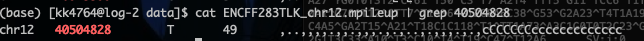

# Try Different Records

In [45]:
18539 - 18527 + 40504816

40504828